<a href="https://colab.research.google.com/github/jjrohal/Data-Science-Projects/blob/main/Earthquake_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Dr. James Rohal (jjrohal@gmail.com)

In the following Jupyter notebook we perform the data analysis to support the four questions put forth for the written assignment for the Data Scientist position at the U.S. Department of State. This question will be split into two sections. In the first section we prepare our data for analysis which is done in the second section. We begin by importing all the libraries we will be using throughout the notebook.

In [ ]:
# numeric libraries
import numpy  as np
import pandas as pd

# for easy GIS data manipulation
!pip install geopandas
import geopandas as gpd

# for grabbing webpage data and webscraping
import requests
from bs4 import BeautifulSoup

# allow for use of Vincenty's formulae to calculate geodesic distance between two latitude/longitude coordinates
import geopy.distance

# for data smoothing
from sklearn.neighbors import KernelDensity

# for plotting
import matplotlib        as mpl
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preparation
---

In this section we prepare the three major data sources for future analysis: embassy and consulate locations, tectonic plate boundaries, and significant earthquakes. We focus on getting latitude and longitude coordinates for all of our data points. In the future, we could link these points to a country by checking whether it lies in a country polygon for broader analysis. 

## Embassy and Consulate Locations

To localize the embassies and consulates on a map we need their latitude and longitude coordinates. To get this data, we will use the website https://www.usembassy.gov/ as a source of truth. We attempt to get these coordinates two different ways: web scraping and manually. We will see that web scraping was a dead end so end up having to manually extract all of the coordinates.

To help with our visualizations, we load all the countries as polygons. 

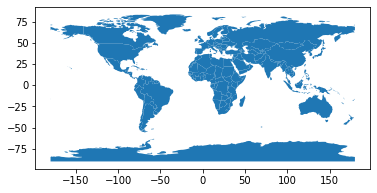

In [ ]:
# load a low resolution version of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# display the world 
world.plot();

### Web Scraping

We first attempted to scrape the addresses from the https://www.usembassy.gov/ site after noticing the addresses seemed to be in a HTML `<div class="cityname1">` tag. Our next step was to extract the full address and then use a geocoder REST API to find the latitude/longitude coordinate. Unfortunately, there are a number of issues with this approach. 
1.   Not every country has an embassy. For instance, we just evacuated our embassy in Afghanistan (https://www.usembassy.gov/afghanistan).
2.   Not every address is in a `<div class="cityname1">` tag. This seems to occur when there is no embedded Google Map. For example, the address for Azerbaijan is in a `<p>` tag (https://www.usembassy.gov/azerbaijan).
3.   Sometimes addresses have phone numbers or other contact information at the end. This contact information is not standardized in any way and could contain Phone, Fax, Tel, Telephone, Call, Main, etc. Sometimes there are multiple lines of contact information, as is the case in Armenia (https://www.usembassy.gov/armenia). 
4.   Sometimes there is no address at all even though there is an embassy. For example, Somalia has an embassy but there is no address on its webpage (https://www.usembassy.gov/somalia).
5.   The geocoder REST APIs usually have a limited number of uses unless you pay.
6.   The geocoder REST APIs are unreliable if the address is malformed. Even if it is well formed, it may return no results. 

Below is a first attempt at trying this webscraping approach using Beautiful Soup as a HTML parser to extract the addresses. We quickly gave up when we saw that for some of the countries no address was returned and thought of the issues above. 

In [ ]:
# grab the content of the main webpage
req_all = requests.get('https://www.usembassy.gov')

# setup the HTML parser to parse the webpage text
soup = BeautifulSoup(req_all.text, 'html.parser')

# initialize storage for all the embassies/consulates as a nested dict
embassy = {}

# loop over all the <a> HTML tags with class="pcs-post-title" as this is where the embassy/consulate URLs are stored
for link in soup.find_all('a', {'class': 'pcs-post-title'}):

    # initialize the dict for the given embassy/consulate
    embassy[link.get('title')] = {}

    # store the url
    embassy[link.get('title')]['url'] =  link.get('href')

    # set up another nested dict to store possibly multiple addresses
    embassy[link.get('title')]['address'] = {}

    # follow each link
    req_individual = requests.get(link.get('href'))

    # build an HTML parser for the page text
    soup = BeautifulSoup(req_individual.text, 'html.parser')

    # loop over all the <div> HTML tags with class="cityname1" as this is where the address is stored
    for address in soup.find_all('div', {'class': 'cityname1'}):

        # get the inner text and then split it on newlines
        exploded_address = address.text.splitlines()

        # drop lines that contain Phone or Fax
        #exploded_address = [line for line in exploded_address if not any(s in line for s in ['Phone','Fax','Tel','Telephone','Call','International','Main','tel'])]
        # store each address: the first line is the name of the embassy/consulate, the rest is the address except for the last line which is likely a phone number
        embassy[link.get('title')]['address'][exploded_address[0]] = ", ".join(exploded_address[1:-1])

In [ ]:
# display the first few embassies and notice some addresses are missing
list(embassy.items())[0:8]

[('Afghanistan',
  {'address': {}, 'url': 'https://www.usembassy.gov/afghanistan/'}),
 ('Albania',
  {'address': {'U.S. Embassy Tirana': 'Rruga e Elbasanit, No. 103, Tirana, ALBANIA'},
   'url': 'https://www.usembassy.gov/albania/'}),
 ('Algeria',
  {'address': {'U.S. Embassy in Algiers': '05 Chemin Cheikh Bachir Ibrahimi, El-Biar 16030, Alger Algerie'},
   'url': 'https://www.usembassy.gov/algeria/'}),
 ('Angola',
  {'address': {'U.S. Embassy in Luanda': 'R. Houari Boumediene 32,, Luanda, Angola,, C.P. 6468'},
   'url': 'https://www.usembassy.gov/angola/'}),
 ('Argentina',
  {'address': {'U.S. Embassy in Buenos Aires': 'Av. Colombia 4300, (C1425GMN) Buenos Aires, Argentina'},
   'url': 'https://www.usembassy.gov/argentina/'}),
 ('Armenia',
  {'address': {'U.S. Embassy in Yerevan': '1 American Avenue, Yerevan 0082, Republic of Armenia, Telephone: (+37410) 464-700'},
   'url': 'https://www.usembassy.gov/armenia/'}),
 ('Australia',
  {'address': {'U.S. Consulate in Melbourne': '553 St. K

### Manual Entry

After realizing that the web scraping approach would require too much time to handle the edge cases, we opted to manually extract the latitude and longitude coordinates for each office location. This was done by visiting each link at https://www.usembassy.gov and using the given address to find the coordinate. We used one of two methods. 

First, if an embedded Google Map existed, then the coordinate could be extracted from the `ll` paramater of the "View Larger Map" link in the embeded iframe. For example, visiting the Argentina page (https://www.usembassy.gov/argentina) has an embedded map with URL https://maps.google.com/maps?ll=-34.576798,-58.418383&z=16&t=m&hl=en-US&gl=US&mapclient=embed&q=Av.%20Colombia%204300%20Buenos%20Aires%20Argentina. In this case, `(latitude, longitude) = (-34.576798,-58.418383)`.

Second, if there was no embedded map, then we used the embassy description or the given address to search for the address on Google Earth. For example, upon visiting the Azerbaijan page (https://www.usembassy.gov/azerbaijan) we noticed there was no map, so we searched Google Earth for "U.S. Embassy in Baku" and found the address matched `(latitude, longtitude) = (40.387019, 49.843134)`. 

Unfortunately, this approach did not always work. For example, Somalia has an embassy but when you search for "U.S. Embassy in Somalia" in Google Earth it returns "Old US Embassy" and "Former U.S. Embassy" addresses (https://www.usembassy.gov/somalia). It was not clear which of these addresses referred to the current embassy. Instead, we visited the embassy webpage (https://so.usembassy.gov) and found a map indicating the embassy location. Regrettably, this map did not have an address or the coordinates we needed after inspection of the underlying HTML. We chose to find the exact location on Google Earth using the map as a guide to extract the coordinates of the marked pin. Suspiciously, when searching for the city Mogadishu on Google Earth, the dropped pin is very close to the one shown on the embassy website. This leads me to believe that the pin on the embassy website is just a generic city marker pin and is not the correct embassy location. However, this is not a huge issue because the earthquake analysis we perform will not be affected by having a little error in the latitude/longitude coordinate. 

In [ ]:
# name : (latitude, longitude)
office_locations = {'U.S. Embassy Tirana' : (41.291882, 19.853680),
'U.S. Embassy in Algiers' : (36.755798, 3.039115),
'U.S. Embassy in Luanda' : (-8.810106,13.245653),
'U.S. Embassy in Buenos Aires' : (-34.576798,-58.418383),
'U.S. Embassy in Yerevan' : (40.165179,44.481577), 
'U.S. Embassy in Canberra' : (-35.306395,149.116328),
'U.S. Consulate in Melbourne' : (-37.846901,144.980025), 
'U.S. Consulate in Perth' : (-31.956857,115.864412),
'U.S. Consulate in Sydney' : (-33.839882,151.206357), 
'U.S. Embassy in Austria' : (48.223086, 16.356858),
'U.S. Embassy in Baku' :  (40.386926, 49.843200), 
'U.S. Mission to ASEAN' : (-6.181252, 106.830187), 
'U.S. Mission to the African Union' : (9.069928, 38.760627),
'U.S. Embassy Nassau' : (25.077309,-77.346808), 
'U.S. Embassy Manama' : (26.237475,50.538751), 
'U.S. Embassy in Dhaka' : (23.794927,90.41434), 
'U.S. Embassy in Bridgetown' : (13.093214, -59.585483), 
'U.S. Embassy Minsk' : (53.913021,27.558755), 
'U.S. Embassy Brussels' : (50.844564, 4.367319), 
'U.S. Embassy in Belmopan' : (17.256638,-88.773146), 
'U.S. Embassy Cotonou' : (6.351221,2.402116), 
'U.S. Consulate in Hamilton' : (32.295246,-64.768097), 
'U.S. Embassy in La Paz' : (-16.512683, -68.121301), 
'U.S. Embassy in Sarajevo' : (43.856665,18.400394), 
'U.S. Embassy Gaborone' : (-24.661266,25.908677), 
'U.S. Embassy in Brasilia' : (-15.804107,-47.873223), 
'U.S. Consulate in Porto Alegre' : (-30.012588,-51.168588), 
'U.S. Consulate General in Recife' : (-8.057466,-34.892932), 
'U.S. Consulate General in Rio de Janeiro' : (-22.911493,-43.173923), 
'U.S. Consulate General in Sao Paulo' : (-23.629402,-46.697492), 
'U.S. Embassy in Bandar Seri Begawan' : (4.920258,114.956721), 
'U.S. Embassy in Sofia' : (42.666789,23.313066), 
'U.S. Embassy in Ouagadougou' : (12.304926,-1.497214), 
'U.S. Embassy in Rangoon' : (16.825369,96.144414), 
'U.S. Embassy in Bujumbura' : (-3.365401,29.380543), 
'U.S. Embassy in Praia' : (14.92112,-23.506373), 
'U.S. Embassy in Phnom Penh' : (11.575259,104.92135), 
'U.S. Embassy in Yaounde' : (3.900228, 11.499589),
'U.S. Embassy in Ottawa' : (45.428007,-75.695957), 
'U.S. Consulate General in Calgary' : (51.046735,-114.058345), 
'U.S. Consulate General in Halifax' : (44.652652,-63.574508), 
'U.S. Consulate General in Montreal' : (45.49944,-73.573238), 
'U.S. Consulate General in Quebec' : (46.810613,-71.204747), 
'U.S. Consulate General in Toronto' : (43.652783,-79.387897), 
'U.S. Consulate General in Vancouver' : (49.28758,-123.119703), 
'U.S. Consulate in Winnipeg' : (49.895522,-97.139199), 
'U.S. Embassy in Bangui' : (4.360142,18.579117), 
'U.S. Embassy in Ndjamena' : (12.100918, 15.048922),
'U.S. Embassy Santiago' : (-33.412671,-70.604492), 
'U.S. Embassy in Beijing' : (39.954559, 116.466835),
'U.S. Consulate General in Guangzhou' : (23.116031, 113.320203),
'U.S. Consulate in Shanghai' : (31.213310, 121.450940),
'U.S. Consulate in Shenyang' : (41.783458,  123.426632), 
'U.S. Consulate General in Wuhan' : (30.594672,  114.271517),
'U.S. Embassy in Bogota' : (4.636928, -74.095014),
'U.S. Virtual Embassy to Comoros' : (-18.858769, 47.475398),
'U.S. Embassy in San Jose' : (9.942677,-84.124042), 
'U.S. Embassy in Abidjan' : (5.335040, -3.976045), 
'U.S. Embassy in Zagreb' : (45.743087, 16.003986), 
'U.S. Embassy Havana' : (23.145879,-82.387632), 
'U.S. Consulate General in Curacao' : (12.107684,-68.925656), 
'U.S. Embassy in Nicosia' : (35.166329, 33.342953),
'U.S. Embassy in Prague' : (50.087334,14.401325), 
'U.S. Embassy in Kinshasa' : (-4.30068,15.31366), 
'U.S. Embassy Copenhagen' : (55.69463,12.583294), 
'U.S. Embassy in Djibouti' : (11.563916,43.16718), 
'U.S. Embassy in Santo Domingo' : (18.509342,-69.963733), 
'U.S. Embassy Quito' : (-0.138687,-78.467555), 
'U.S. Consulate General Guayaquil' : (-2.191271,-79.939318), 
'U.S. Embassy in Cairo' : (30.041246,31.233294), 
'U.S. Consulate General in Alexandria' : (31.24555,30.017697), 
'U.S. Embassy in San Salvador' : (13.664367,-89.258025), 
'U.S. Embassy in Malabo' : (3.751243,8.754937), 
'U.S. Embassy Asmara' : (15.329156,38.935456), 
'U.S. Embassy in Tallinn' : (59.430495,24.751646), 
'U.S. Embassy Mbabane' : (-26.326479,31.145843), 
'U.S. Embassy in Addis Ababa' : (9.058498,38.763829), 
'U.S. Mission to the EU': (50.844159, 4.367224),
'U.S. Embassy in Suva' : (-18.116936,178.43959), 
'U.S. Embassy in Finland' : (60.157353,24.960888), 
'U.S. Embassy in Paris' : (48.867477,2.320281), 
'U.S. Consulate Bordeaux' : (44.854175,-0.566289), 
'U.S. Consulate Lyon' : (45.763034,4.837468), 
'U.S. Consulate General Marseille' : (43.290586,5.379096), 
'U.S. Consulate Rennes' : (48.110272,-1.684424), 
'U.S. Consulate General Strasbourg' : (48.58706,7.761484), 
'U.S. Embassy in Libreville' : (0.484369,9.395694), 
'U.S. Embassy Tbilisi' : (41.788317,44.77611), 
'U.S. Embassy in Berlin' : (52.452213, 13.272043),
'U.S. Consulate General in Düsseldorf' : (51.218619, 6.795467),
'U.S. Consulate General in Frankfurt' : (50.140646, 8.693837), 
'U.S. Consulate General in Hamburg' : (53.562160, 9.997030),
'U.S. Consulate General in Leipzig' : (51.333896,  12.368352),
'U.S. Consulate General in Munich' : (48.145146, 11.583574), 
'U.S. Embassy in Accra' : (5.57948,-0.170623), 
'U.S. Embassy in Athens' : (37.982039,23.746694), 
'U.S. Consulate in Thessaloniki' : (40.633303,22.942451), 
'U.S. Embassy in Guatemala City' : (14.599430, -90.514424), 
'U.S. Embassy Conakry' : (9.595030, -13.636633), 
'U.S. Virtual Consulate in Guinea-Bissau' : (14.745183,-17.526161), 
'U.S. Embassy in Georgetown' : (6.82308,-58.160961), 
'U.S. Embassy in Banjul' : (13.461994,-16.686824), 
'U.S. Embassy in Port-au-Prince' : (18.564096,-72.249333), 
'U.S. Embassy to the Holy See': (41.905780, 12.491583), 
'U.S. Embassy Tegucigalpa' : (14.103376,-87.190209), 
'U.S. Consulate General in Hong Kong' : (22.27818,114.158644),
'U.S. Embassy in Budapest' : (47.50446,19.051414), 
'U.S. Embassy in Reykjavik' : (64.143799,-21.9376), 
'U.S. Embassy in New Delhi': (28.590186,77.186939),
'U.S. Consulate General in Chennai' : (13.052305,80.251949), 
'U.S. Consulate General in Hyderabad' : (17.441471,78.47409), 
'U.S. Consulate General in Kolkata' : (22.550996,88.349543), 
'U.S. Consulate General in Mumbai' : (19.072582,72.871135), 
'U.S. Embassy Jakarta' : (-6.180564,106.830591), 
'U.S. Consulate General Surabaya' : (-7.283654,112.647953), 
'U.S. Consulate Medan' : (-7.61329,111.898409), 
'U.S. Consular Agency Bali' : (-8.672959,115.244227), 
'U.S. Embassy in Tehran' : (35.771504,51.465172), 
'U.S. Embassy in Baghdad' : (33.298742, 44.395913),
'U.S. Consulate General in Erbil' : (36.226461, 43.990642), 
'U.S. Embassy in Dublin' : (53.330361, -6.233526), 
'U.S. Embassy Jerusalem' : (31.747612,35.224549),
'U.S. Embassy Rome' : (41.906593,12.49078), 
'U.S. Consulate General Florence' : (43.7738,11.24052), 
'U.S. Consulate General Milan' : (45.475097,9.194197), 
'U.S. Consulate General in Naples' : (40.831103,14.225825), 
'U.S. Mission to the ICAO' : (45.500356,-73.563219), 
'U.S. Embassy in Kingston' : (18.018467,-76.764854),
'U.S. Embassy in Tokyo' : (35.668805, 139.743326), 
'U.S. Embassy in Amman' : (31.945097,35.880556), 
'U.S. Embassy in Astana' : (51.128833,71.469108), 
'U.S. Consulate General Almaty' : (43.233531,76.954127), 
'U.S. Embassy Nairobi' : (-1.234160, 36.810523), 
'U.S. Embassy in Pristina' : (42.661995,21.150551), 
'U.S. Embassy Kuwait City' : (29.291611,48.046871), 
'U.S. Embassy in Bishkek' : (42.827776,74.582561), 
'U.S. Embassy Vientiane' : (17.896299,102.640172), 
'U.S. Embassy in Riga' : (56.93097,24.030166),
'U.S. Embassy in Beirut' : (33.934694, 35.597835),
'U.S. Embassy in Maseru' : (-29.306638, 27.468296), 
'U.S. Embassy in Monrovia' : (6.316433, -10.813357),
'U.S. Embassy in Tripoli' : (32.8872, 13.1913),
'U.S. Embassy in Vilnius' : (54.684061,25.270661), 
'U.S. Embassy in Luxembourg' : (49.618971,  6.129034),
'U.S. Embassy in Antananarivo' : (-18.881111, 47.500695),
'U.S. Embassy in Lilongwe' : (-13.962431, 33.786683), 
'U.S. Embassy in Kuala Lumpur' : (3.154958, 101.722561), 
'U.S. Virtual Mission in Maldives' : (6.913233,79.848618), 
'U.S. Embassy in Bamako' : (12.629849,-8.018906), 
'U.S. Embassy Valletta' : (35.890653,14.426845), 
'U.S. Embassy Majuro' : (7.138854,171.205968),
'U.S. Embassy in Nouakchott' : (18.097847,-15.996271), 
'U.S. Embassy in Port Louis' : (-20.161991,57.500475), 
'U.S. Embassy in Mexico City' : (19.428387, -99.166330),
'U.S. Consulate General in Ciudad Juarez' : (31.689107, -106.405134),
'U.S. Consulate General in Guadalajara' : (20.673437, -103.367111),
'U.S. Consulate General in Hermosillo' : (29.078587, -110.958766),
'U.S. Consulate General in Matamoros' : (25.888770, -97.499036),
'U.S. Consulate General in Merida' : (20.989136, -89.619825),
'U.S. Consulate General in Monterrey' : (25.660732, -100.443723),
'U.S. Consulate General in Nogales' : (31.288652, -110.940002), 
'U.S. Consulate General in Nuevo Laredo' : (27.466029, -99.506958),
'U.S. Consulate General in Tijuana' : (32.523324, -116.952467),
'U.S. Embassy in Kolonia' : (6.957380, 158.216346), 
'U.S. Embassy in Chisinau' : (47.021521,28.818999),
'U.S. Embassy in Ulaanbaatar' : (47.928314,106.930247),
'U.S. Embassy in Podgorica' : (42.436921,19.251193), 
'U.S. Embassy Rabat' : (33.955802,-6.824677), 
'U.S. Consulate General Casablanca' : (33.590838,-7.626588),
'U.S. Embassy Maputo' : (-25.959560, 32.600331),
'U.S. Embassy Windhoek' : (-22.575615,17.084861),
'U.S. Embassy in Kathmandu' : (27.738235, 85.335312),
'U.S. Embassy The Hague' : (52.099287,4.345574),
'U.S. Consulate General Amsterdam' : (52.356189,4.882077),
'U.S. Embassy Wellington' : ( -41.273261,  174.779002),
'U.S. Embassy Managua' : (12.124279, -86.312694), 
'U.S. Embassy Niamey' : (13.526345,2.072995),
'U.S. Embassy Abuja' : ( 9.023928,  7.439087),
'U.S. Embassy in Skopje' : (41.99909,21.42489),
'U.S. Embassy in Oslo' : ( 59.941433,  10.669203),
'U.S. Mission to the OSCE' : (48.234463,16.419973),
'U.S. Mission to the OAS' : (38.893783,-77.048875),
'U.S. Mission to the OECD' : (48.868297,2.317074),
'U.S. Embassy in Islamabad' : (33.723954,73.117969), 
'U.S. Consulate General Karachi' : (24.841193,67.009598), 
'U.S. Consulate General Lahore' : (31.560164,74.336202),
'U.S. Consulate General Peshawar' : (34.005843,71.537053), 
'U.S. Embassy in Koror' : (7.359623,134.551223), 
'U.S. Embassy in Panama City' : (8.999415, -79.561920),
'U.S. Embassy in Port Moresby' : (-9.470708,  147.152647),
'U.S. Embassy in Asuncion' : (-25.293178,-57.603965),
'U.S. Embassy in Lima' : ( -12.100674, -76.968945), 
'U.S. Embassy in Manila' : (14.560576,  120.985895), 
'U.S. Embassy Warsaw' : (52.2245,21.023611), 
'U.S. Consulate General in Krakow' : (50.059814,19.938833), 
'U.S. Consular Agency in Poznan' : (52.407776,16.930153), 
'U.S. Embassy Lisbon' : (38.744109,-9.163324), 
'U.S. Consulate Ponta Delgada Azores' : (37.744855,-25.67855), 
'U.S. Embassy Doha' : (25.303591, 51.471237), 
'U.S. Embassy in Brazzaville' : (-4.275341,15.256185),
'U.S. Embassy Bucharest' : (44.514694,26.086398), 
'U.S. Embassy Moscow' : (55.75602,37.579165), 
'U.S. Consulate General in Vladivostok' : (43.115336,131.909319), 
'U.S. Consulate General in Yekaterinburg' : (56.833227,60.610165),
'U.S. Embassy Apia' : (-13.832368,-171.768232), 
'U.S. Embassy in San Marino' : (41.906593,12.49078),
'U.S. Embassy in Riyadh' : (24.681222,46.620972),
'U.S. Consulate General in Dhahran' : (24.68125,46.621374),
'U.S. Consulate General in Jeddah' : (21.526285,39.161933), 
'U.S. Embassy in Dakar' : (14.745183,  -17.526161),
'U.S. Embassy in Belgrade' : (44.77249,20.453249), 
'U.S. Virtual Presence Post Seychelles' : (-20.161991, 57.500475),
'U.S. Embassy in Freetown' : (8.451708,-13.229848),
'U.S. Embassy Pretoria': (-25.746365,  28.223893),
'U.S. Embassy Seoul': (37.573139, 126.977871),
'U.S. Embassy in Juba' : (4.855728,31.586054),
'U.S. Embassy in Madrid': (40.434654, -3.687244),
'U.S. Embassy Colombo' : (6.913233,79.848618),
'U.S. Embassy in Khartoum' : (15.526245,32.607639),
'U.S. Embassy in Paramaribo' : (5.864254,-55.127225),
'U.S. Embassy in Stockholm' : (59.333664,18.105543),
'U.S. Embassy Bern' : (46.943433,7.438283),
'U.S. Virtual Mission Liechtenstein' : (46.943433,7.438283), 
'U.S. Embassy in Damascus' : ( 33.516239, 36.317184),
'American Institute in Taiwan' : ( 25.080773,  121.598273),
'U.S. Embassy in Dushanbe': (38.579465,68.712176),
'U.S. Embassy in Dar es Salaam' : (-6.772637, 39.266112),
'U.S. Embassy Bangkok' : (13.736036,100.547462),
'U.S. Consulate General Chiang Mai' : (18.79412,98.998685),
'U.S. Embassy in Dili' : (-8.546047,125.550396),
'U.S. Embassy in Lome' : (6.185463,1.214235),
'U.S. Embassy in Tonga' : (-18.116936,178.43959),
'U.S. Embassy in Port of Spain' : (10.665946, -61.516514),
'U.S. Embassy Tunis' : (36.850425,10.270178),
'U.S. Embassy Ankara' : (39.908221,32.856147),
'U.S. Consulate General Istanbul' : (41.118425,29.046167),
'U.S. Consulate Adana' : (36.982742,35.385272),
'U.S. Embassy Ashgabat' : (37.901252,58.389387),
'U.S. Mission-Geneva' : (46.232739,6.137318),
'U.S. Mission Rome' : (41.907845,12.492086),
'U.S. Mission to the United Nations' : (40.750667,-73.968902),
'U.S. Embassy in Kampala' : (0.30101,32.59169),
'U.S. Embassy in Kyiv' : (50.464994,30.432056),
'U.S. Embassy in Abu Dhabi' : (24.424399, 54.433710),
'U.S. Embassy London' : (51.482566,-0.132237),
'U.S. Consulate General in Belfast' : (54.571427,-5.943764),
'U.S. Consulate General in Edinburgh' : (55.954268,-3.177746),
'U.S. Embassy Montevideo' : (-34.913503,-56.176185),
'U.S. Embassy in Tashkent' : (41.367161,69.272481),
'U.S. Mission to the International Organizations in Vienna' : (48.234712,  16.420857),
'U.S. Embassy in Caracas' : (10.475384, -66.871427),
'U.S. Embassy in Hanoi' : (21.02162,105.818977),
'U.S. Consulate in Ho Chi Minh City' : (10.783478,106.700601),
'U.S. Embassy in Sana’a' : (15.373052,44.229863), 
'U.S. Embassy in Lusaka' : (-15.417944,  28.367744),
'U.S. Embassy in Harare' : ( -17.793907, 31.011820)}


To efficiently use this data, we convert it to a GeoDataFrame.

In [ ]:
# load the dict as data frame with latitude and longitude as the columns
office_locations = pd.DataFrame.from_dict(office_locations, orient='index', columns=['latitude','longitude'])

# convert this to a GeoDataFrame using (longitude, latitude) as the geometry
office_locations = gpd.GeoDataFrame(office_locations, geometry=gpd.points_from_xy(x=office_locations['longitude'], y=office_locations['latitude']))

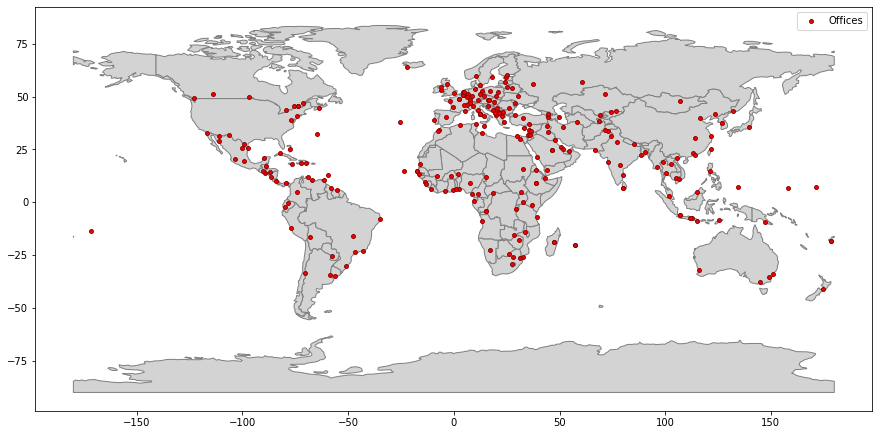

In [ ]:
# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# plot the embassies as red dots
office_locations.plot(ax=ax_world, color='red', edgecolor='darkred', markersize=15, label='Offices')
# show the legend
ax_world.legend();

We augment this data set by identifying which country the embassy or consulate office is in according to the country polygons given in our world data set. This is also a sanity check to see if we have incorrect geodetic office locations. 

In [ ]:
# import Point structure to check containment
from shapely.geometry import Point

# initialize an empty column to store the country for each office
office_locations['Country'] = ''

# initialize an empty column to store a flag indicating whether the office has a matching polygon in the world data set
office_locations['Country Assigned'] = False

# loop over each office
for name, latitude, longitude in office_locations[['latitude','longitude']].itertuples():
    # for debugging, keep track of which offices were not assigned
    assigned = False

    # loop over each country
    for idx, country in world.iterrows():
        # check if office location is in the country polygon
        if country['geometry'].contains(Point(longitude,latitude)):
            # store the name
            office_locations.at[name,'Country'] = country['name']
            # mark it as assigned
            office_locations.at[name,'Country Assigned'] = True
            assigned = True

    # after looping through all the countries see if this office was left unassigned for debugging
    if not assigned:
        print(name + ' was not assigned')

U.S. Embassy Nassau was not assigned
U.S. Embassy Manama was not assigned
U.S. Embassy in Bridgetown was not assigned
U.S. Consulate in Hamilton was not assigned
U.S. Consulate General in Recife was not assigned
U.S. Embassy in Praia was not assigned
U.S. Embassy Havana was not assigned
U.S. Consulate General in Curacao was not assigned
U.S. Embassy in Djibouti was not assigned
U.S. Embassy in Malabo was not assigned
U.S. Embassy in Georgetown was not assigned
U.S. Consular Agency Bali was not assigned
U.S. Embassy in Tripoli was not assigned
U.S. Virtual Mission in Maldives was not assigned
U.S. Embassy Valletta was not assigned
U.S. Embassy Majuro was not assigned
U.S. Embassy in Port Louis was not assigned
U.S. Embassy in Kolonia was not assigned
U.S. Embassy in Koror was not assigned
U.S. Consulate Ponta Delgada Azores was not assigned
U.S. Embassy Apia was not assigned
U.S. Virtual Presence Post Seychelles was not assigned
U.S. Embassy in Freetown was not assigned
U.S. Embassy Col

Because the country polygons are low resolution and do not contain all the world's countries, the embassies and consulates above were not assigned a country during our loop. We manually add the ones that are contained in the world data set.

In [ ]:
# assign the countries and change their assignment flags
# we could make a loop and use a one liner but the below was easier. ex: office_locations.loc['U.S. Embassy in Djibouti',['Country','Country Assigned']] = np.array(['Djibouti', True])
office_locations.loc['U.S. Embassy Nassau','Country']                          = 'Bahamas'
office_locations.loc['U.S. Embassy Nassau','Country Assigned']                 = True
office_locations.loc['U.S. Consulate General in Recife','Country']             = 'Brazil'
office_locations.loc['U.S. Consulate General in Recife','Country Assigned']    = True
office_locations.loc['U.S. Embassy Havana','Country']                          = 'Cuba'
office_locations.loc['U.S. Embassy Havana','Country Assigned']                 = True
office_locations.loc['U.S. Embassy in Djibouti','Country']                     = 'Djibouti'
office_locations.loc['U.S. Embassy in Djibouti','Country Assigned']            = True
office_locations.loc['U.S. Embassy in Malabo','Country']                       = 'Eq. Guinea'
office_locations.loc['U.S. Embassy in Malabo','Country Assigned']              = True
office_locations.loc['U.S. Embassy in Georgetown','Country']                   = 'Guyana'
office_locations.loc['U.S. Embassy in Georgetown','Country Assigned']          = True
office_locations.loc['U.S. Consular Agency Bali','Country']                    = 'Indonesia'
office_locations.loc['U.S. Consular Agency Bali','Country Assigned']           = True
office_locations.loc['U.S. Embassy in Tripoli','Country']                      = 'Libya'
office_locations.loc['U.S. Embassy in Tripoli','Country Assigned']             = True
office_locations.loc['U.S. Consulate Ponta Delgada Azores','Country']          = 'Portugal'
office_locations.loc['U.S. Consulate Ponta Delgada Azores','Country Assigned'] = True
office_locations.loc['U.S. Embassy in Freetown','Country']                     = 'Sierra Leone'
office_locations.loc['U.S. Embassy in Freetown','Country Assigned']            = True
office_locations.loc['U.S. Embassy Colombo','Country']                         = 'Sri Lanka'
office_locations.loc['U.S. Embassy Colombo','Country Assigned']                = True
office_locations.loc['U.S. Embassy Tunis','Country']                           = 'Tunisia'
office_locations.loc['U.S. Embassy Tunis','Country Assigned']                  = True
office_locations.loc['U.S. Consulate General Istanbul','Country']              = 'Turkey'
office_locations.loc['U.S. Consulate General Istanbul','Country Assigned']     = True
office_locations.loc['U.S. Embassy Montevideo','Country']                      = 'Uruguay'
office_locations.loc['U.S. Embassy Montevideo','Country Assigned']             = True

# the rest do not have a matching polygon in our dataset
office_locations.loc['U.S. Embassy Manama','Country']                   = 'Bahrain'
office_locations.loc['U.S. Embassy in Bridgetown','Country']            = 'Barbados'
office_locations.loc['U.S. Consulate in Hamilton','Country']            = 'Bermuda'
office_locations.loc['U.S. Embassy in Praia','Country']                 = 'Cape Verde'
office_locations.loc['U.S. Consulate General in Curacao','Country']     = 'Curacao'
office_locations.loc['U.S. Virtual Mission in Maldives','Country']      = 'Maldives'
office_locations.loc['U.S. Embassy Valletta','Country']                 = 'Malta'
office_locations.loc['U.S. Embassy Majuro','Country']                   = 'Marshall Islands'
office_locations.loc['U.S. Embassy in Port Louis','Country']            = 'Mauritius'
office_locations.loc['U.S. Embassy in Kolonia','Country']               = 'Federated States of Micronesia'
office_locations.loc['U.S. Embassy in Koror','Country']                 = 'Palau'
office_locations.loc['U.S. Embassy Apia','Country']                     = 'Samoa'
office_locations.loc['U.S. Virtual Presence Post Seychelles','Country'] = 'Seychelles'

## Tectonic Plates

We will extract tectonic plates and their boundaries as shapefiles from a Github repository (https://github.com/fraxen/tectonicplates) which converted the original digital files from `Bird, P. (2003), An updated digital model of plate boundaries, Geochem. Geophys. Geosyst., 4, 1027, doi:10.1029/2001GC000252, 3.` The boundaries will be stored in a GeoDataFrame for efficient analysis.

In [ ]:
# clone the repository to add the shapefiles to our local directory in the tectonicplates folder
!git clone https://github.com/fraxen/tectonicplates

# we only need the boundaries of the tectonic plates
# note: the coordinates are (longitude, latitude)
tectonic_boundaries = gpd.read_file('tectonicplates/PB2002_boundaries.shp')

fatal: destination path 'tectonicplates' already exists and is not an empty directory.


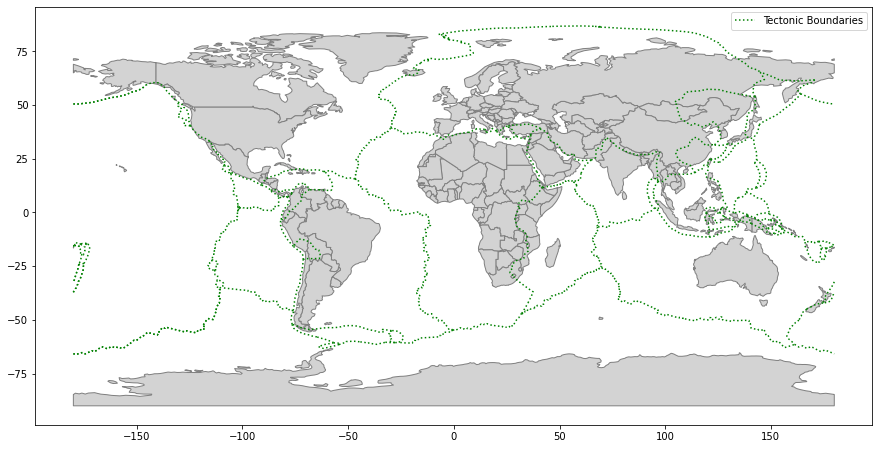

In [ ]:
# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# plot the embassies as orange lines
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundaries')
# show the legend
ax_world.legend();

## Significant Earthquakes

We will use the global listing of significant earthquakes on or after the year 1970 provided with this assignment. This set of earthquakes is a subset of the larger database NCEI/WDS Global Significant Earthquake Database (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ngdc.mgg.hazards:G012153) which contains over 5700 significant earthquakes from 2150 BC to the present. A description of the columns is given on the ISO 19115-2 Metadata page (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ngdc.mgg.hazards:G012153;view=iso). We copy a small amount of these descriptions in the table below that are relevant to our analysis.

| Column           | Description |
| -----------      | ----------- |
| Latitude         | Distance measured north or south from the equator. Distance north is positive, distance south is negative.       |
| Longitude        | Longitude is measured from the Prime Meridian (which is the north/south line that runs through Greenwich, England), values measured east are positive and values measured west are negative.       |
| Focal Depth (km) |   The depth of the earthquake is given in kilometers, positive downward.   |
| Mag              |  The value in this column contains the primary earthquake magnitude. Magnitude measures the energy released at the source of the earthquake. Magnitude is determined from measurements <br /> on seismographs. For pre-instrumental events, the magnitudes are derived from intensities. There are several different scales for measuring earthquake magnitudes. The primary magnitude is chosen <br /> from the available magnitude scales in this order: Mw Magnitude, Ms Magnitude, Mb Magnitude, Ml Magnitude, Mfa Magnitude, Unknown Magnitude           |
| Damage Description | For those events not offering a monetary evaluation of damage, the following five-level scale was used to classify damage (1990 dollars) and was listed in the Damage Description column. If the actual <br /> dollar amount of damage was listed, a descriptor was also added for search purposes. When possible, a rough estimate was made of the dollar amount of damage based upon the description provided, <br /> in order to choose the damage category. In many cases, only a single descriptive term was available. These terms were converted to the damage categories based upon the authors apparent use of the <br /> term elsewhere. In the absence of other information, LIMITED is considered synonymous with slight, minor, and light, SEVERE as synonymous with major, extensive, and heavy, and EXTREME as <br />synonymous with catastrophic. Note: The descriptive terms relate approximately to current dollar values. The values range from 0-4 where <br /> 0 = NONE, <br /> 1 = LIMITED (roughly corresponding to less than \$1 million), <br /> 2 = MODERATE (\~\$1 to \$5 million), <br />3 = SEVERE (\~>\$5 to \$24 million), <br />4 = EXTREME (\~\$25 million or more).|

In [ ]:
# read the provided excel file in as a DataFrame
earthquakes = pd.read_excel('Data Set - Earthquakes.xlsx')

# clean the data
# drop first row and first column
earthquakes = earthquakes.iloc[1: , 1:] 

# drop any row that has a missing Latitude, Longitude, or Mag entry
earthquakes = earthquakes.dropna(subset=['Latitude', 'Longitude','Mag'])

# convert it to a GeoDataFrame for easy plotting
earthquakes = gpd.GeoDataFrame(earthquakes, geometry=gpd.points_from_xy(x=earthquakes['Longitude'], y=earthquakes['Latitude']))

Take a quick look at the first few rows of the data frame as a sanity check.

In [ ]:
earthquakes.head()

,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,Latitude,...,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description,geometry
1,1970.0,1.0,4.0,17.0,0.0,40.2,NaN,NaN,CHINA: YUNNAN PROVINCE; VIETNAM: HANOI,24.1,...,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,POINT (102.50000 24.10000)
2,1970.0,1.0,10.0,12.0,7.0,8.6,2019.0,NaN,PHILIPPINES: MINDANAO,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (126.70000 6.80000)
3,1970.0,2.0,5.0,22.0,5.0,58.3,NaN,NaN,"PHILIPPINES: LUZON, ROMBLON I; TABLAS I: ODI...",12.6,...,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,POINT (122.10000 12.60000)
4,1970.0,2.0,14.0,11.0,17.0,16.1,NaN,NaN,"PERU: PANAO,CHACLLA,QUERO,AYLLAMARCA,LA LINDA",-9.9,...,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,POINT (-75.60000 -9.90000)
5,1970.0,3.0,11.0,22.0,38.0,34.6,3309.0,NaN,ALASKA: ANDREANOF ISLANDS,57.5,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,POINT (-153.90000 57.50000)


# Analysis
---

In this section we lay out four different approaches for answering the question, "Which embassies are most at risk?"

## Methods 1 and 2 - Exploratory Data Analysis

We begin with an elementary exploratory data analysis approach to start getting familiar with the data.

First, we plot the geometries of our three major data sets. As expected, there are a lot more earthquakes along the tectonic boundaries.

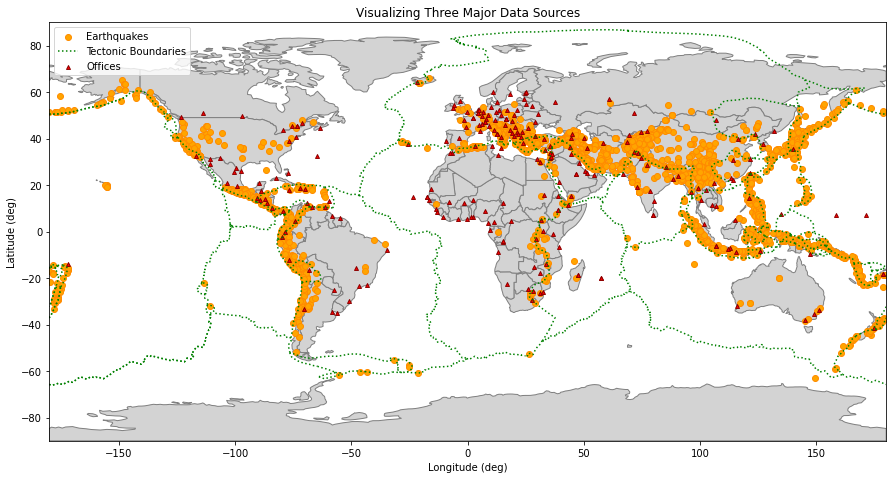

In [ ]:
# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# draw the earthquake locations
earthquakes.plot(ax=ax_world, label='Earthquakes', color='orange', edgecolor='darkorange')
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundaries')
# draw the embassies
office_locations.plot(ax=ax_world, marker='^', color='red', edgecolor='darkred', markersize=15, label='Offices')
# draw the legend
ax_world.legend(loc='upper left')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)');
# title
ax_world.set_title('Visualizing Three Major Data Sources')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);


It may be reasonable to assume then that embassies closer to tectonic boundaries are at a higher risk. To compute the shortest distance from the embassy to the tectonic boundary we consider all the pairwise geodetic distances between the embassy and the coordinates defining the tectonic boundaries. 

In [ ]:
# add a new column in the data frame to store the shortest distance to the tectonic boundary
office_locations['Distance to Tectonic'] = np.NaN

# loop over each office location
for name, location in office_locations.iterrows():
    # set the min distance to be large initially and update each loop
    min_distance_all = 1e9

    # loop over each tectonic boundary
    for boundary in tectonic_boundaries['geometry']:
        # find minimum geodesic distance in kilometers from location to boundary
        # the coordinates must be (latitude, longitude) for this to work...the tectonic boundary is reversed
        min_distance = np.min([geopy.distance.geodesic([location['latitude'], location['longitude']], reversed(boundary_coord)).km for boundary_coord in boundary.coords])

        # see if we found a smaller minimum
        if min_distance < min_distance_all:
            min_distance_all = min_distance

    # store the minimum distance amongst all the pairwise distances
    office_locations.at[name,'Distance to Tectonic'] = min_distance_all

By sorting the distance in ascending order, we can identify which embassies are closest to the tectonic boundary, and thus have a higher risk of earthquake damage. 

In [ ]:
# sort by distance in ascending order
office_locations.sort_values(by='Distance to Tectonic').head(20)

,latitude,longitude,geometry,Country,Country Assigned,Distance to Tectonic,Earthquake Density,Amplitude Sum Total,Peak Ground Acceleration,id
U.S. Consulate Ponta Delgada Azores,37.744855,-25.678550,POINT (-25.67855 37.74486),Portugal,True,4.704991,6.470590e-05,950.740301,0.000000,242
U.S. Embassy Wellington,-41.273261,174.779002,POINT (174.77900 -41.27326),New Zealand,True,17.843727,3.505200e-04,10436.002565,0.107620,80
U.S. Embassy in Caracas,10.475384,-66.871427,POINT (-66.87143 10.47538),Venezuela,True,21.151770,6.918435e-05,823.213924,0.346237,20
U.S. Embassy in Reykjavik,64.143799,-21.937600,POINT (-21.93760 64.14380),Iceland,True,25.461559,1.131378e-04,10820.555274,0.000000,232
U.S. Embassy in Port of Spain,10.665946,-61.516514,POINT (-61.51651 10.66595),Trinidad and Tobago,True,26.546276,3.556922e-04,7689.251974,0.211711,48
U.S. Embassy in Beirut,33.934694,35.597835,POINT (35.59784 33.93469),Lebanon,True,27.641083,5.374192e-05,230.360878,0.485221,9
U.S. Consulate General Peshawar,34.005843,71.537053,POINT (71.53705 34.00584),Pakistan,True,28.669776,4.038970e-04,5858.125352,0.203240,53
U.S. Consulate in Shenyang,41.783458,123.426632,POINT (123.42663 41.78346),China,True,28.972974,7.959251e-05,3560.135669,0.000000,246
U.S. Embassy Vientiane,17.896299,102.640172,POINT (102.64017 17.89630),Thailand,True,29.296399,9.493974e-07,153.482398,0.034485,129
American Institute in Taiwan,25.080773,121.598273,POINT (121.59827 25.08077),Taiwan,True,29.602526,9.736738e-04,34201.668766,0.349049,19


We can visually confirm our distances were correct by drawing earthquakes as cooler blue colors when they are further from the tectonic boundary and warmer red colors when they are closer to the tectonic boundary. 

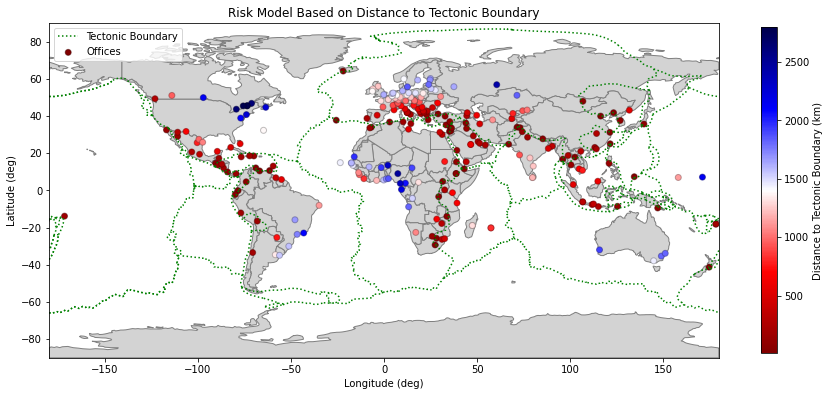

In [ ]:
# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundary')
# draw the earthquake locations
# use a slightly modified edge color for each point based on the color assigned to it in the colormap
# we do this by scaling all the amplitudes by the max to be between [0,1] and then index into the colormap, we then multiply by a fraction to make it darker
cmap        = mpl.cm.get_cmap('seismic_r')
edge_colors = 1/2*cmap(office_locations['Distance to Tectonic']/np.max(office_locations['Distance to Tectonic']))
office_locations.plot(ax=ax_world, column='Distance to Tectonic', cmap='seismic_r', edgecolor=edge_colors, label='Offices', legend=True, legend_kwds={'shrink': 0.4, 'label': 'Distance to Tectonic Boundary (km)'})
# draw the legend
ax_world.legend(loc='upper left')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Risk Model Based on Distance to Tectonic Boundary')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

We also want to only show the top 20 embassies most at risk on the map by themselves.

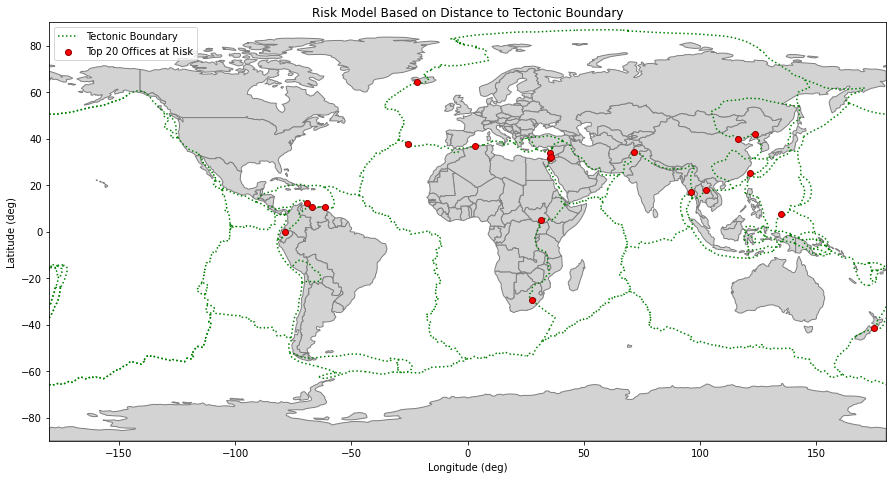

In [ ]:
# get the first 20 embassies in the sorted dataframe
office_locations_at_risk = office_locations.sort_values(by='Distance to Tectonic').head(20)

# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray',zorder=0)
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundary',zorder=1)
# draw the earthquake locations
office_locations_at_risk.plot(ax=ax_world, color='red', edgecolor='darkred', label='Top 20 Offices at Risk')
# draw the legend
ax_world.legend(loc='upper left')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Risk Model Based on Distance to Tectonic Boundary')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

Just being along a fault line is not the ultimate indicator of risk though. We can see this by plotting earthquakes along with their magnitudes. We color the higher magnitude earthquakes darker red than the lower magnitude ones in yellow. It would seem being along the fault line that runs N-S in South America is worse (because of the frequency of darker red dots) than being along the fault line that runs N-S along South Africa (because of the frequency of lighter yellow dots). This would indicate that the distance analysis we perform should be augmented with an approach that takes in to account the magnitude. This observation led me to come up with the empirical model in the next section.

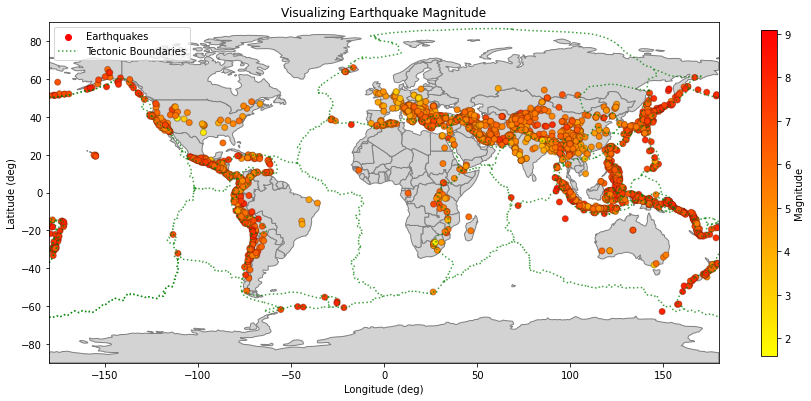

In [ ]:
# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# draw the earthquake locations
# use a slightly modified edge color for each point based on the color assigned to it in the colormap
# we do this by scaling all the amplitudes by the max to be between [0,1] and then index into the colormap, we then multiply by a fraction to make it darker
cmap        = mpl.cm.get_cmap('autumn_r')
edge_colors = 1/2*cmap(earthquakes['Mag']/np.max(earthquakes['Mag']))
earthquakes.plot(ax=ax_world, column='Mag', edgecolor=edge_colors, cmap='autumn_r', legend=True, legend_kwds={'shrink': 0.4, 'label': 'Magnitude'}, label='Earthquakes')
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color=(0,0.5,0,0.75), linestyle=':', label='Tectonic Boundaries') # add some opacity
# draw the legend
leg = ax_world.legend(loc='upper left')
# manually set the earthquakes color on the legend so it is more visible
leg.legendHandles[0].set_color('red')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)');
# title
ax_world.set_title('Visualizing Earthquake Magnitude')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

We can smooth the data points above using a weighted kernel density estimation. Here we use the geodetic earthquake locations as the independently distributed samples with weights given by the magnitude. We build a function called `WeightedKernelDensityLongLat` for use later. 

In [ ]:
# assume the locations are given as (longitude, latitude) coordinates
def WeightedKernelDensityLongLat(locations_longlat, weights=None, x_extent=[-180,180], y_extent=[-90,90], cell_size=0.1, kernel='gaussian', bandwidth=1.0):
    # get bounds on grid
    x_min = x_extent[0]
    x_max = x_extent[1]
    y_min = y_extent[0]
    y_max = y_extent[1]

    # create grid based on bounds and cell size
    # use arrays to hold longitude (x) locations and latitude (y) locations for each pixel in the output raster
    x = np.arange(x_min, x_max, cell_size)
    y = np.arange(y_min, y_max, cell_size)

    # create a meshgrid, which has cells whose values are the (x,y) location at each cell
    xx, yy = np.meshgrid(x, y)

    # pair the x locations with y locations
    xy = np.vstack((xx.ravel(), yy.ravel())).T

    # Get the kernel density estimator
    # by default we use haversine distance instead of the geopy geodesic distance to simplify things. if you wanted to use the geodesic distance then there is no need to conver the coordinates to radians below
    #kde = KernelDensity(bandwidth=bandwidth, metric='haversine', kernel=kernel, algorithm='ball_tree')
    kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel=kernel, algorithm='ball_tree')

    # Fit it to the coordinate pairs
    # make sure the coordinates are converted to radians to use the haversine distance
    #_ = kde.fit(np.array(locations_longlat) * (np.pi / 180.0), sample_weight=weights)
    _ = kde.fit(locations_longlat, sample_weight=weights)

    # evaluate and reshape
    z = np.exp(kde.score_samples(xy))
    z = z.reshape((len(y), len(x)))

    # return
    return x, y, z, kde

We draw our kernel density estimation overlaid on our map and see that it aligns with the earthquake locations.

In [ ]:
# compute the KDE using magnitude as the weights
x, y, z, kde = WeightedKernelDensityLongLat(list(zip(earthquakes['Longitude'],earthquakes['Latitude'])), 
                                       weights = list(earthquakes['Mag']), cell_size = 0.5)

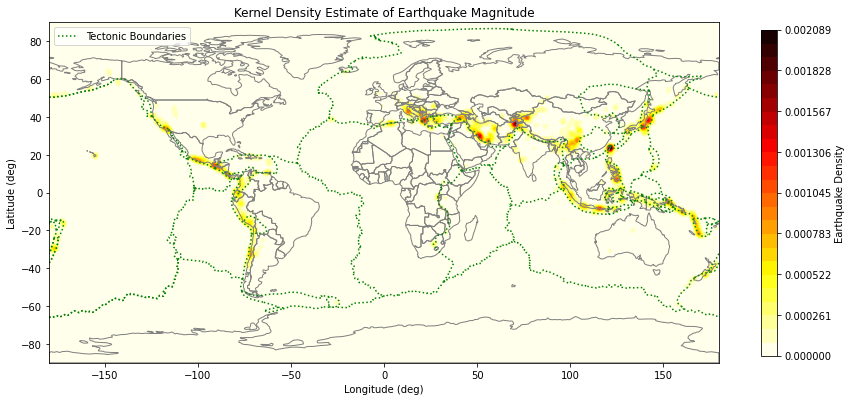

In [ ]:
# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='none', edgecolor='gray', zorder=1)
# plot contours of the density
levels = np.linspace(0, z.max(), 25)
cnt = ax_world.contourf(x, y, z, levels=levels, cmap='hot_r',zorder=0)
plt.colorbar(cnt, shrink=0.4, label='Earthquake Density')
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, linestyle=':', color='green', label='Tectonic Boundaries',zorder=2)
# draw the legend
leg = ax_world.legend(loc='upper left')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)');
# title
ax_world.set_title('Kernel Density Estimate of Earthquake Magnitude')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

Our first risk model will take advantage of our kernel density estimation. We can use our smoothed probability density function to compute the density for each office location. Office locations with higher density would then be at more risk of earthquake damage.

In [ ]:
# add a new column in the data frame to store the earthquake density
office_locations['Earthquake Density'] = 0

# loop over each office
for name, office in office_locations.iterrows():
    # compute and store the density
    office_locations.loc[name,'Earthquake Density'] = np.exp(kde.score_samples(np.array([[office['longitude'], office['latitude']]])))

We show the top 20 offices at risk according to the calculated earthquake density measure and then plot them along with the kernel density estimation.

In [ ]:
# sort by density in descending order to show highest risk
office_locations.sort_values(by='Earthquake Density',ascending=False).head(20)

,latitude,longitude,geometry,Country,Country Assigned,Distance to Tectonic,Earthquake Density,Amplitude Sum Total,Peak Ground Acceleration,id
U.S. Embassy in Guatemala City,14.599430,-90.514424,POINT (-90.51442 14.59943),Guatemala,True,56.307955,0.001021,22389.336445,0.626685,4
U.S. Embassy in Tokyo,35.668805,139.743326,POINT (139.74333 35.66880),Japan,True,86.139202,0.001017,40890.840561,0.000000,206
American Institute in Taiwan,25.080773,121.598273,POINT (121.59827 25.08077),Taiwan,True,29.602526,0.000974,34201.668766,0.349049,19
U.S. Consular Agency Bali,-8.672959,115.244227,POINT (115.24423 -8.67296),Indonesia,True,275.204833,0.000967,10851.891391,0.276433,34
U.S. Embassy in San Salvador,13.664367,-89.258025,POINT (-89.25803 13.66437),El Salvador,True,116.499758,0.000965,53409.613770,0.618142,5
U.S. Embassy in San Jose,9.942677,-84.124042,POINT (-84.12404 9.94268),Costa Rica,True,56.164707,0.000888,57672.742778,0.557091,8
U.S. Embassy Tirana,41.291882,19.853680,POINT (19.85368 41.29188),Albania,True,285.481687,0.000818,23243.542900,0.000000,211
U.S. Embassy in Podgorica,42.436921,19.251193,POINT (19.25119 42.43692),Montenegro,True,378.831335,0.000705,38127.204403,0.000000,200
U.S. Embassy in Algiers,36.755798,3.039115,POINT (3.03911 36.75580),Algeria,True,38.463226,0.000692,19959.813679,0.058814,108
U.S. Embassy Quito,-0.138687,-78.467555,POINT (-78.46756 -0.13869),Ecuador,True,32.335462,0.000643,27385.084827,0.753809,2


In [ ]:
# https://stackoverflow.com/questions/51350872/python-from-color-name-to-rgb
# to get rgba values from color names
from matplotlib import colors

print('green = ' + str(colors.to_rgba('green')))
print('gray = ' + str(colors.to_rgba('gray')))

green = (0.0, 0.5019607843137255, 0.0, 1.0)
gray = (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 1.0)


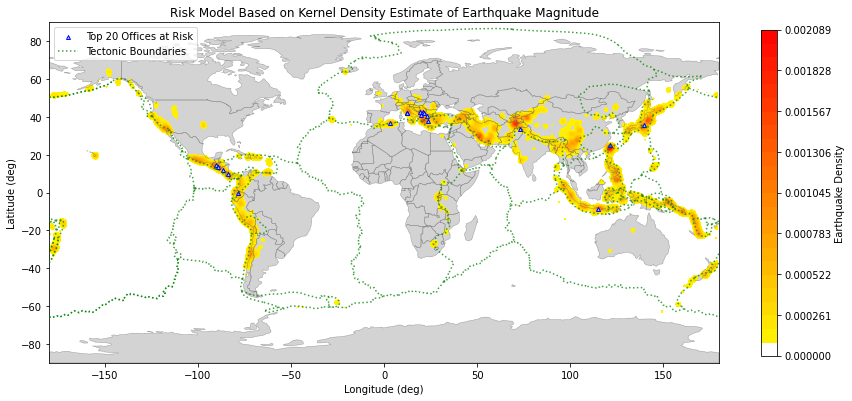

In [ ]:
# the top 20 offices at risk according to Earthquake Density
office_locations_at_risk = office_locations.sort_values(by='Earthquake Density',ascending=False).head(20)

# for creating copies
import copy

# create a custom colormap that makes the first few values of a LinearSegmentedColormap a different color
# we do this so we can "mask out" the low z values in the contour plot
# https://stackoverflow.com/questions/40713566/mask-two-groups-of-values-in-matlotlib-colormap-with-gradual-colorscheme
my_cmap = copy.copy(plt.get_cmap('autumn_r')) # create a copy of the original so we don't modify it for other plots
my_cmap._init()
my_cmap._lut[0:6, :] = (1,1,1,0) # <~~~~complete opacity = (#,#,#,0), black = (1,1,1,1), white = (1,1,1,1), 

# draw the world as a basemap, we draw it twice so we can draw the country boundaries over the contours (notice the zorder)
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='none', zorder=0)
world.plot(ax=ax_world, color='none', edgecolor=(0.35,0.35,0.35,0.5), zorder=2, linewidth=0.5) # make the lines have a bit of opacity
#ax_world.set_facecolor('snow')
# plot contours of the density
levels = np.linspace(0, z.max(), 25)
cnt = ax_world.contourf(x, y, z, levels=levels, cmap=my_cmap, zorder=1)
plt.colorbar(cnt, shrink=0.4, label='Earthquake Density')
# draw the offices
office_locations_at_risk.plot(ax=ax_world, marker='^', color='lightblue', edgecolor='blue', markersize=15, label='Top 20 Offices at Risk', zorder=2)
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, linestyle=':', color=(0,0.5,0,0.75), label='Tectonic Boundaries',zorder=3) # make the lines have a bit of opacity
# draw the legend
leg = ax_world.legend(loc='upper left')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)');
# title
ax_world.set_title('Risk Model Based on Kernel Density Estimate of Earthquake Magnitude')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

We also want to only show the top 20 embassies most at risk on the map by themselves.

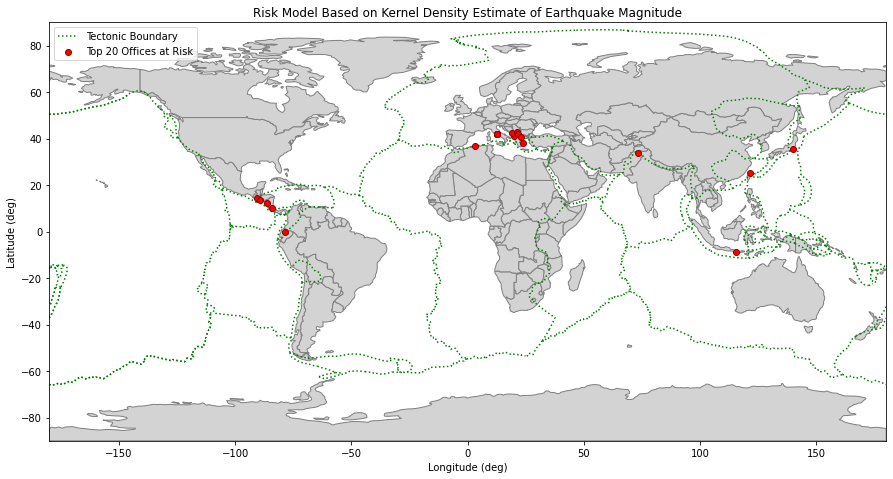

In [ ]:
# the top 20 offices at risk according to Earthquake Density
office_locations_at_risk = office_locations.sort_values(by='Earthquake Density',ascending=False).head(20)

# plot the country boundaries as the basemap
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray',zorder=0)
# draw the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundary',zorder=1)
# draw the earthquake locations
office_locations_at_risk.plot(ax=ax_world, color='red', edgecolor='darkred', label='Top 20 Offices at Risk')
# draw the legend
ax_world.legend(loc='upper left')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Risk Model Based on Kernel Density Estimate of Earthquake Magnitude')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

To explore the rest of the earthquakes data set, we first check to see how many missing values are there as a percentage of the total data. We see that this is a really sparse data set. The values for magnitude and focal depth are well represented as is the damage description. Unless we find a reason otherwise, we will ignore the other columns.

In [ ]:
# how many missing values are there as a percentage of the total data
earthquakes.isna().sum()/len(earthquakes)*100

Year                                   0.000000
Mo                                     0.000000
Dy                                     0.000000
Hr                                     0.090992
Mn                                     0.181984
Sec                                    0.409463
Tsu                                   76.842584
Vol                                   99.135578
Location Name                          0.000000
Latitude                               0.000000
Longitude                              0.000000
Focal Depth (km)                       0.682439
Mag                                    0.000000
MMI Int                               62.511374
Deaths                                56.551410
Death Description                     55.686988
Missing                               98.953594
Missing Description                   98.999090
Injuries                              50.818926
Injuries Description                  45.768881
Damage ($Mil)                         80

To get a super high level view of the dataset, we look at histograms of all the columns. Nothing particularly interesting jumps out except that magnitude appears to be normally distributed with mean around 6.08. 

In [ ]:
# compute mean of magnitude
np.mean(earthquakes['Mag'])

6.078525932666059

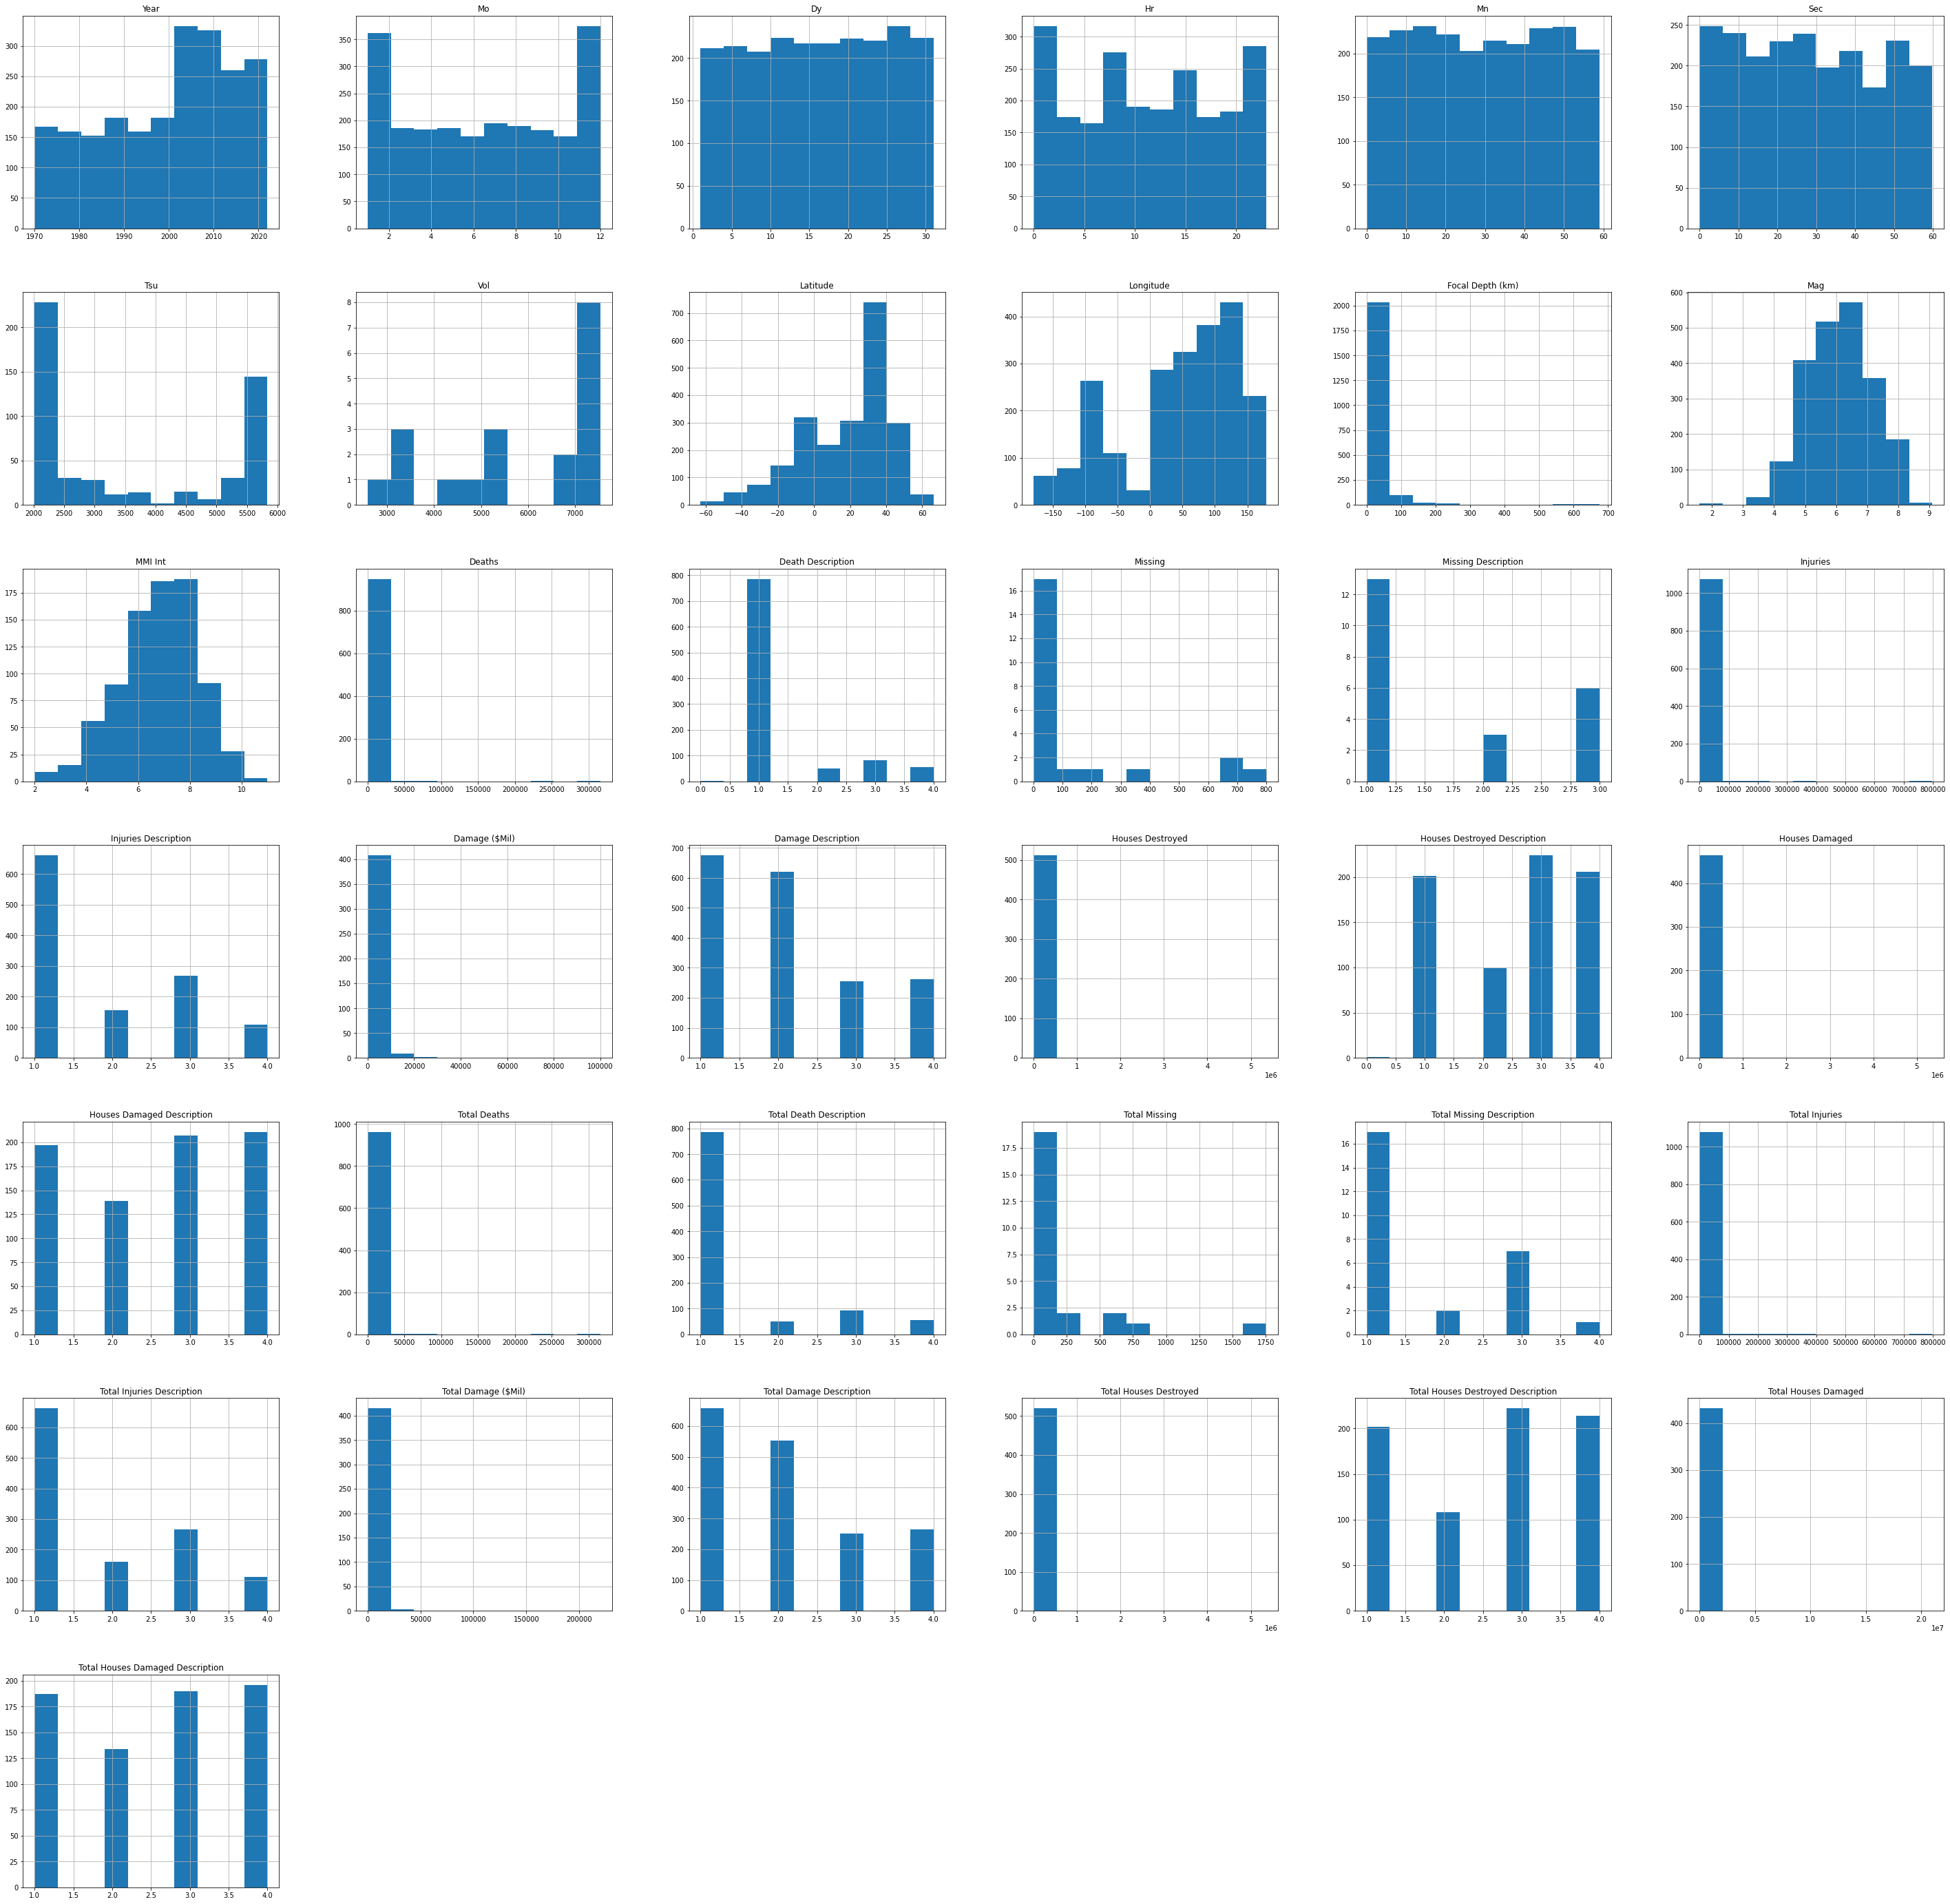

In [ ]:
# draw histograms of all the columns
earthquakes.hist(figsize=(50,50));

We may notice that 10km shows up quite a lot in the focal depth. This is because many areas around the world reliable depths tend to average 10 km (https://www.usgs.gov/faqs/why-do-so-many-earthquakes-occur-depth-10km).

In [ ]:
# find which depth occurs most
earthquakes['Focal Depth (km)'].mode()

0    10.0
dtype: float64

## Method 3 - Empirical Model

As observed earlier when measuring the distance from the embassies to the tectonic boundaries, we saw that while being close to a boundary is an indicator of risk, not all boundaries are identical. In the 1930's, Charles Richter introduced what is now called the local magnitude $M_L$ (which is column Mag in our earthquakes data set). The magnitude was determined by measuing the largest amplitude $A$ on a standard instrument, the Wood-Anderson seismograph. Researchers computed an empirical formula (`Shearer, P. Introduction to seismology. Cambridge University Press, 2019. pp. 281`) relating local magnitude, maximum amplitude, and epicentral distance $10 < X < 600$ in kilometers given by:

$$M_L = \log_{10}A + 2.56\log_{10}X - 1.67.$$

Solving for $A$ gives:

$$A = 10^{M_L - 2.56\log_{10}X + 1.67}.$$

We will use the above relation to calculate the maximum amplitude an embassy experiences for each earthquake in our data set. We would expect larger amplitudes will likely cause more damage. Embassies that experience a larger sum total of these amplitudes would likely be at more risk.

We can find the distance from an embassy to the epicenter in our earthquake dataset by first computing its geodesic distance $G$ and use the depth of the earthquake $D$ to compute its epicentral distance $X = \sqrt{G^2 + D^2}$. We will remove earthquakes in our dataset that do not have a recorded magnitude or depth.


In [ ]:
# add a new column in the data frame to store the sum total of amplitudes
office_locations['Amplitude Sum Total'] = np.NaN

# drop the earthquakes that do not have a depth or magnitude
earthquakes_with_depths = earthquakes.dropna(subset=['Focal Depth (km)'])

# also drop the earthquakes that have 0 depth
earthquakes_with_depths = earthquakes_with_depths[earthquakes_with_depths['Focal Depth (km)'] != 0]

# loop over each embassy
for name, location in office_locations.iterrows():
    # initialize the sum total for the given location
    sum_total = 0

    # loop over each earthquake
    for idx, earthquake in earthquakes_with_depths.iterrows():
        # compute the geodesic distance (km)
        G = geopy.distance.geodesic([location['latitude'], location['longitude']], [earthquake['Latitude'], earthquake['Longitude']]).km

        # compute the epicentral distance
        X = np.sqrt(G**2 + earthquake['Focal Depth (km)']**2)

        # make sure X isn't too small or too big
        if 10 < X and X < 600:
            # compute the amplitude
            A = 10 ** (earthquake['Mag'] - 2.56*np.log10(X) + 1.67)

            # add the amplitude to the sum total
            sum_total += A

    # store the sum total
    office_locations.at[name,'Amplitude Sum Total'] = sum_total

To see which offices are at highest risk, we can sort the amplitudes in descending order. Those with the highest sum total amplitude are the ones having the highest risk.

In [ ]:
# sort by value descending to see the embassies with highest sum totals
office_locations.sort_values(by='Amplitude Sum Total',ascending=False)

,latitude,longitude,geometry,Country,Country Assigned,Distance to Tectonic,Earthquake Density,Amplitude Sum Total,Peak Ground Acceleration,id
U.S. Embassy in Lima,-12.100674,-76.968945,POINT (-76.96895 -12.10067),Peru,True,186.109377,4.640908e-04,72604.413836,0.572009,7
U.S. Embassy Santiago,-33.412671,-70.604492,POINT (-70.60449 -33.41267),Chile,True,210.037715,4.884639e-04,67963.705195,0.585210,6
U.S. Embassy in San Jose,9.942677,-84.124042,POINT (-84.12404 9.94268),Costa Rica,True,56.164707,8.882089e-04,57672.742778,0.557091,8
U.S. Embassy in Port-au-Prince,18.564096,-72.249333,POINT (-72.24933 18.56410),Haiti,True,194.158159,2.204187e-04,56389.568540,0.285239,32
U.S. Embassy in Kathmandu,27.738235,85.335312,POINT (85.33531 27.73823),Nepal,True,69.005676,2.325167e-04,54310.570589,0.405788,15
...,...,...,...,...,...,...,...,...,...,...
U.S. Embassy Montevideo,-34.913503,-56.176185,POINT (-56.17618 -34.91350),Uruguay,True,1544.456611,7.125033e-34,0.000000,0.005977,181
U.S. Consulate in Porto Alegre,-30.012588,-51.168588,POINT (-51.16859 -30.01259),Brazil,True,1566.678492,3.986852e-18,0.000000,0.000000,245
U.S. Embassy in Accra,5.579480,-0.170623,POINT (-0.17062 5.57948),Ghana,True,1571.794184,5.875051e-17,0.000000,0.058524,109
U.S. Embassy in Bamako,12.629849,-8.018906,POINT (-8.01891 12.62985),Mali,True,1601.958182,1.408812e-11,0.000000,0.000006,185


Before we plot the data, let us quickly summarize it using a box plot and histogram. We see that much of the data lies below the 75% percentile. This would seem to indicate that the majority of embassies are not in major risk. The offices beyond the 75% should be studied in more detail.

count      256.000000
mean      4477.719976
std      11433.036262
min          0.000000
25%          4.231608
50%        126.328213
75%       2698.339974
max      72604.413836
Name: Amplitude Sum Total, dtype: float64

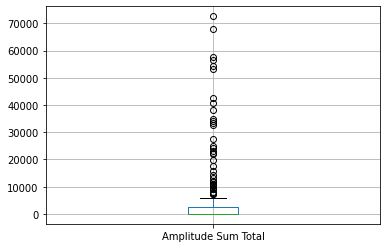

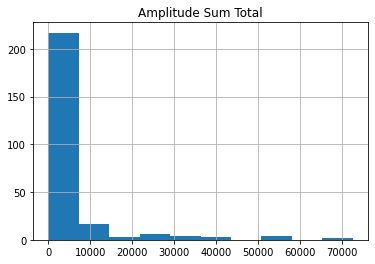

In [ ]:
# quickly summarize the data
office_locations.boxplot(column='Amplitude Sum Total')
office_locations.hist(column='Amplitude Sum Total')
office_locations['Amplitude Sum Total'].describe()

We extract only the offices beyond the 75th percentile as these are the ones with highest risk. 

In [ ]:
# the ones at risk are the ones that have experienced amplitudes from significant earthquakes (which have a sum total > 0)
# to help with plotting, we only show those in the 75th percentile
office_locations_at_risk = office_locations[office_locations['Amplitude Sum Total'] > office_locations['Amplitude Sum Total'].quantile(0.75)]

# show the top 20 offices with highest risk
office_locations_at_risk.sort_values(by='Amplitude Sum Total', ascending=False).head(20)

,latitude,longitude,geometry,Country,Country Assigned,Distance to Tectonic,Earthquake Density,Amplitude Sum Total,Peak Ground Acceleration,id
U.S. Embassy in Lima,-12.100674,-76.968945,POINT (-76.96895 -12.10067),Peru,True,186.109377,0.000464,72604.413836,0.572009,7
U.S. Embassy Santiago,-33.412671,-70.604492,POINT (-70.60449 -33.41267),Chile,True,210.037715,0.000488,67963.705195,0.585210,6
U.S. Embassy in San Jose,9.942677,-84.124042,POINT (-84.12404 9.94268),Costa Rica,True,56.164707,0.000888,57672.742778,0.557091,8
U.S. Embassy in Port-au-Prince,18.564096,-72.249333,POINT (-72.24933 18.56410),Haiti,True,194.158159,0.000220,56389.568540,0.285239,32
U.S. Embassy in Kathmandu,27.738235,85.335312,POINT (85.33531 27.73823),Nepal,True,69.005676,0.000233,54310.570589,0.405788,15
U.S. Embassy in San Salvador,13.664367,-89.258025,POINT (-89.25803 13.66437),El Salvador,True,116.499758,0.000965,53409.613770,0.618142,5
U.S. Embassy Managua,12.124279,-86.312694,POINT (-86.31269 12.12428),Nicaragua,True,169.272656,0.000590,42412.997935,0.768457,1
U.S. Embassy in Tokyo,35.668805,139.743326,POINT (139.74333 35.66880),Japan,True,86.139202,0.001017,40890.840561,0.000000,206
U.S. Embassy in Podgorica,42.436921,19.251193,POINT (19.25119 42.43692),Montenegro,True,378.831335,0.000705,38127.204403,0.000000,200
U.S. Consulate in Thessaloniki,40.633303,22.942451,POINT (22.94245 40.63330),Greece,True,120.147493,0.000583,34922.108001,0.341597,21


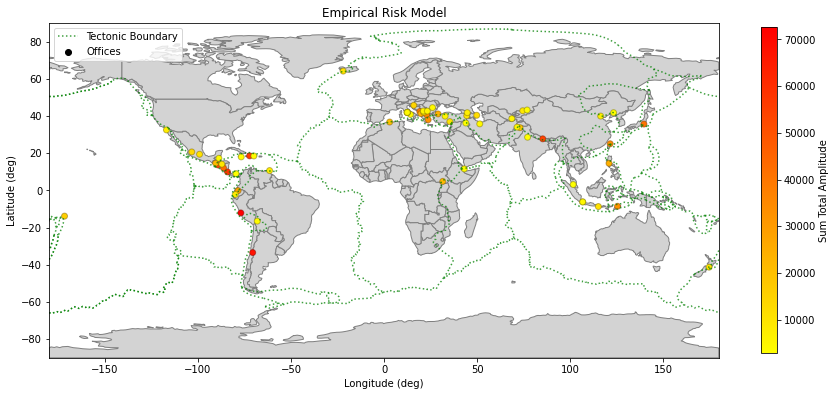

In [ ]:
# plot the world as a base map
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# plot the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color=(0,0.5,0,0.75), linestyle=':', label='Tectonic Boundary') # add some opacity
# plot the locations
# use a slightly modified edge color for each point based on the color assigned to it in the colormap
# we do this by scaling all the amplitudes by the max to be between [0,1] and then index into the colormap, we then multiply by a fraction to make it darker
cmap        = mpl.cm.get_cmap('autumn_r')
edge_colors = 1/2*cmap(office_locations_at_risk['Amplitude Sum Total']/np.max(office_locations_at_risk['Amplitude Sum Total']))
office_locations_at_risk.plot(ax=ax_world, column='Amplitude Sum Total', cmap='autumn_r', edgecolor=edge_colors, label='Offices', legend=True, legend_kwds={'shrink': 0.4, 'label': 'Sum Total Amplitude'})
# show the legend
leg = ax_world.legend(loc='upper left')
# the earthquakes point wasn't showing up due to the colormap, so we manually set it
leg.legendHandles[1].set_color('black')
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Empirical Risk Model')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

Repeat the same plot as above but only show the top 20.

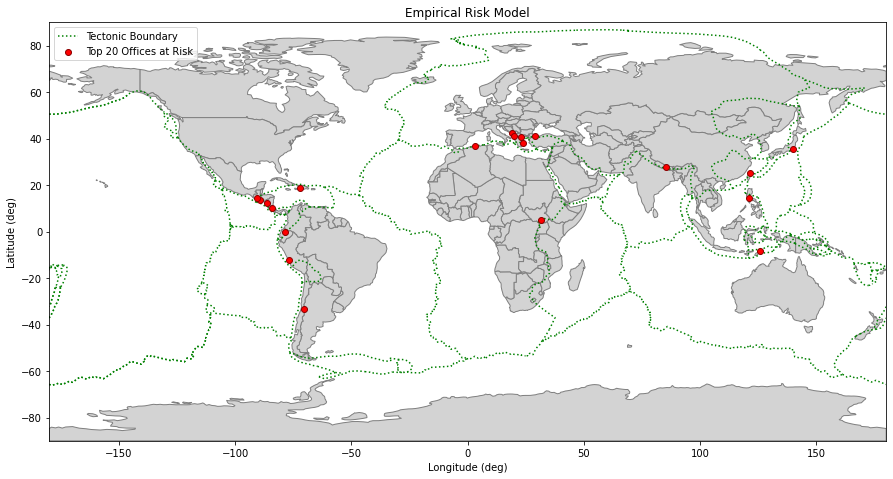

In [ ]:
# grab the top 20 as the dataframe is already sorted
office_locations_at_risk = office_locations.sort_values(by='Amplitude Sum Total',ascending=False).head(20)

# plot the world as a base map
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray',zorder=0)
# plot the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundary',zorder=1)
# plot the locations
office_locations_at_risk.plot(ax=ax_world, color='red', edgecolor='darkred', label='Top 20 Offices at Risk')
# show the legend
leg = ax_world.legend(loc='upper left');
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Empirical Risk Model')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

## Method 4 - Global Seismic Hazard Model

The goal here is to extract the values from the Global Seismic Hazard Map (https://maps.openquake.org/map/global-seismic-hazard-map) which depicts the geographic distribution of the Peak Ground Acceleration (PGA) with a 10% probability of being exceeded in 50 years. PGA equals the maximum ground acceleration that occurs during earthquake shaking at a location, so larger PGA values (warmer colors on the map) are areas that are likely to experience more damage during an earthquake. The United States Geological Survey developed an Instrumental Intensity scale, which maps peak ground acceleration on an intensity scale similar to the felt Mercalli scale. These values are used to create shake maps by seismologists around the world. The table shown below comes from https://en.wikipedia.org/wiki/Peak_ground_acceleration:

| Instrumental Intensity | Peak Ground Acceleration (g) | Perceived Shaking | Potential Damage |
| ----------- | ----------- | ----------- | ----------- |
| I      | \< 0.000464  | Not felt | None |
| II-III   | 0.000464 - 0.00297 | Weak | None |
| IV | 0.00297 - 0.0276 | Light | None |
| V | 0.0276 - 0.115 | Moderate | Very light|
| VI | 0.115 - 0.215 | Strong | Light | 
| VII | 0.215 - 0.401 | Very strong | Moderate | 
| VIII | 0.401 - 0.747 | Severe | Moderate to heavy |
| IX | 0.747 - 1.39 | Violent | Heavy | 
| X+ | \> 1.39 | Extreme | Very heavy |

The full Global Seismic Hazard Map is shown below. The map was created by collating maps computed using national and regional probabilistic seismic hazard models developed by various institutions and projects, and by Global Earthquake Model Foundation scientists.

Unfortunately, the Global Seismic Hazard Map does not have an easily accessible API. To get a PGA value, one must click a location on the map. Upon inspection of the network data, this creates a call to https://maps.openquake.org/api/project/ghm/getfeatureinfo with several parameters based on the click that returns a parsable XML with the PGA value. With some experimentation, we learned the fixed parameters to this call are: 
* width=1707
* height=718
* layers=seismic-hazard-pga-g
* is_inpage=true
* format=text%2Fxml
* disagg_layer_name=

The variable parameters we needed to determine were:
* bbox=min_x, min_y, max_x, max_y of the bounding box centered at (x,y) in the map coordinate system
* x=x-coordinate of the center of the bbox
* y=y-coordinate of the center of the bbox
* lat=latitude of the target where you click
* long=longitude of the target where you click

We also realized that the URL of the map location has the following form https://maps.openquake.org/map/global-seismic-hazard-map/#ZOOM_LEVEL/LATITUDE/LONGITUDE where ZOOM_LEVEL is an increasing large zoom level \[2,4,6,8\] and LATITUDE and LONGITUDE are where the map gets centered on the screen. Using this knowledge, our plan was to look at the URL parameters formed when clicking in the top left corner of the following maximum zoom level maps:
* https://maps.openquake.org/map/global-seismic-hazard-map/#8/0/0.003
* https://maps.openquake.org/map/global-seismic-hazard-map/#8/1/0.003

These maps are off by 1 deg in latitude. The goal is to figure out a way to translate 1 geodetic degree to the mapping coordinate system. With this in hand, we could form a bounding box around the center point which we will use to represent our target longitude/latitude coordinate. Note that we use 0.003 for longitude instead of 0 because the map automatically changed the URL when we put in 0/0. 

With some experimentation we found that (x,y)=(0,0) represented the top left corner while the middle of the map would be represented by ((1707-1)/2, 718/2) = (853, 359). By taking the bboxs from each of the URL responses, we found that the mapping uses a resolution of 111292.313183/deg. With this in hand, we could craft our URL and get the XML response and extract the PGA for any given target latitude and longitude.

In [ ]:
# function to help extract the PGA from the Global Seismic Hazard Map
def PGA(target_longitude, target_latitude):
    # this bounding box was originally centered at [305.748113141, 0] but we want it centered at longitude, latitude = [0,0]
    # so take bounding box and shift it by the midpoint
    boundingbox_longitude = np.array([-521606.2810180429, 522217.7772443243]) - (522217.7772443243 + (-521606.2810180429))/2
    boundingbox_latitude  = np.array([-219527.14523502538,219527.14523502724])

    # the center of the bounding box is the (x,y) coordinate we want to send with the request
    # the width of all the bounding boxes is 1707
    middle_x = int((1707-1)/2)
    # the height of all the bounding boxes is 718
    middle_y = int(718/2)

    # shift the bounding box so that its center is now [target_longitude, target_latitude] 
    # the calculate resolution is 111292.313183/deg
    boundingbox_longitude += target_longitude*111292.313183
    boundingbox_latitude  += target_latitude*111292.313183

    # craft the request
    # %2C = ,
    # %2F = /
    request_url = f'https://maps.openquake.org/api/project/ghm/getfeatureinfo?width=1707&height=718&bbox={boundingbox_longitude[0]}%2C{boundingbox_latitude[0]}%2C{boundingbox_longitude[1]}%2C{boundingbox_latitude[1]}&layers=seismic-hazard-pga-g&x={middle_x}&y={middle_y}&lat={target_latitude}&lng={target_longitude}&is_inpage=true&format=text%2Fxml&disagg_layer_name='

    # send the request
    hazard_request = requests.get(request_url)

    # setup the XML parser to parse the webpage text
    soup = BeautifulSoup(hazard_request.text, 'xml')

    # return the PGA
    return float(soup.find_all('Attribute')[0].get('value'))

# add a new column in the data frame to store the PGA values
office_locations['Peak Ground Acceleration'] = np.NaN

# loop over each embassy
for name, location in office_locations.iterrows():
    # get latitude and longitude
    target_longitude = location['longitude']
    target_latitude  = location['latitude']

    # store the PGA
    try:
        office_locations.at[name,'Peak Ground Acceleration'] = PGA(target_longitude, target_latitude)
    except:
        print('ERROR LAT: ' + str(target_latitude))
        print('ERROR LONG: ' + str(target_longitude))

To see which offices are at highest risk, we can sort the peak ground acceleration in descending order. Those with the highest PGA are the ones having the highest risk.

In [ ]:
# sort by value descending to see the embassies with highest sum totals
office_locations.sort_values(by='Peak Ground Acceleration',ascending=False,inplace=True)
# show the offices
office_locations.head(20)

,latitude,longitude,geometry,Country,Country Assigned,Distance to Tectonic,Earthquake Density,Amplitude Sum Total,Peak Ground Acceleration,id
U.S. Consulate General Guayaquil,-2.191271,-79.939318,POINT (-79.93932 -2.19127),Ecuador,True,52.206180,0.000217,8171.062215,0.868218,0
U.S. Embassy Managua,12.124279,-86.312694,POINT (-86.31269 12.12428),Nicaragua,True,169.272656,0.000590,42412.997935,0.768457,1
U.S. Embassy Quito,-0.138687,-78.467555,POINT (-78.46756 -0.13869),Ecuador,True,32.335462,0.000643,27385.084827,0.753809,2
U.S. Consulate General Istanbul,41.118425,29.046167,POINT (29.04617 41.11843),Turkey,True,48.029411,0.000282,24118.967232,0.667420,3
U.S. Embassy in Guatemala City,14.599430,-90.514424,POINT (-90.51442 14.59943),Guatemala,True,56.307955,0.001021,22389.336445,0.626685,4
U.S. Embassy in San Salvador,13.664367,-89.258025,POINT (-89.25803 13.66437),El Salvador,True,116.499758,0.000965,53409.613770,0.618142,5
U.S. Embassy Santiago,-33.412671,-70.604492,POINT (-70.60449 -33.41267),Chile,True,210.037715,0.000488,67963.705195,0.585210,6
U.S. Embassy in Lima,-12.100674,-76.968945,POINT (-76.96895 -12.10067),Peru,True,186.109377,0.000464,72604.413836,0.572009,7
U.S. Embassy in San Jose,9.942677,-84.124042,POINT (-84.12404 9.94268),Costa Rica,True,56.164707,0.000888,57672.742778,0.557091,8
U.S. Embassy in Beirut,33.934694,35.597835,POINT (35.59784 33.93469),Lebanon,True,27.641083,0.000054,230.360878,0.485221,9


As before with the total sum amplitude metric, it seems like the data is skewed. Let us quickly summarize it using a box plot and histogram. We see that much of the data lies below the 75% percentile. This would seem to indicate that the majority of embassies are not in major risk. The offices beyond the 75% should be studied in more detail.

count    256.000000
mean       0.108285
std        0.157812
min       -0.000062
25%        0.000000
50%        0.034657
75%        0.151817
max        0.868218
Name: Peak Ground Acceleration, dtype: float64

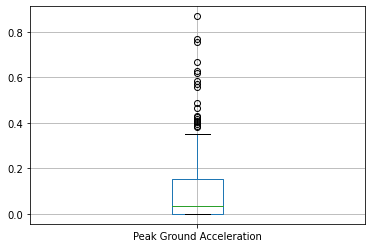

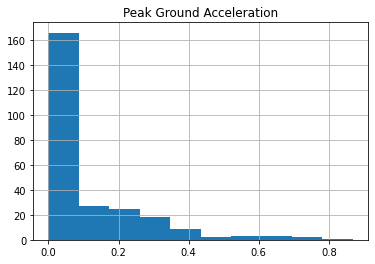

In [ ]:
# quickly summarize the data
office_locations.boxplot(column='Peak Ground Acceleration')
office_locations.hist(column='Peak Ground Acceleration')
office_locations['Peak Ground Acceleration'].describe()

We extract only the offices beyond the 75th percentile as these are the ones with highest risk. 

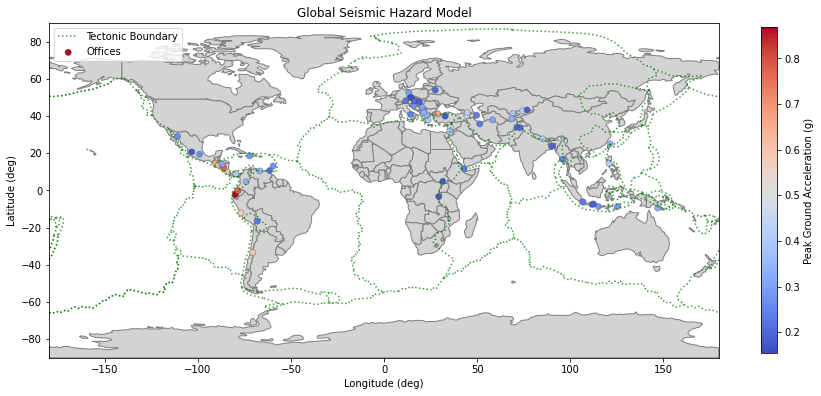

In [ ]:
# the ones at risk are the ones that have experienced amplitudes from significant earthquakes (which have a sum total > 0)
# to help with plotting, we only show those in the 75th percentile
office_locations_at_risk = office_locations[office_locations['Peak Ground Acceleration'] > office_locations['Peak Ground Acceleration'].quantile(0.75)]

# plot the world as a base map
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray')
# plot the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color=(0,0.5,0,0.75), linestyle=':', label='Tectonic Boundary') # add some opacity
# use a slightly modified edge color for each point based on the color assigned to it in the colormap
# we do this by scaling all the amplitudes by the max to be between [0,1] and then index into the colormap, we then multiply by a fraction to make it darker
cmap        = mpl.cm.get_cmap('coolwarm')
edge_colors = 1/2*cmap(office_locations_at_risk['Peak Ground Acceleration']/np.max(office_locations_at_risk['Peak Ground Acceleration']))
office_locations_at_risk.plot(ax=ax_world, column='Peak Ground Acceleration', cmap='coolwarm', edgecolor=edge_colors, label='Offices', legend=True, legend_kwds={'shrink': 0.4, 'label': 'Peak Ground Acceleration (g)'})
# show the legend
leg = ax_world.legend(loc='upper left');
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Global Seismic Hazard Model')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

Repeat the same plot as above but only show the top 20.

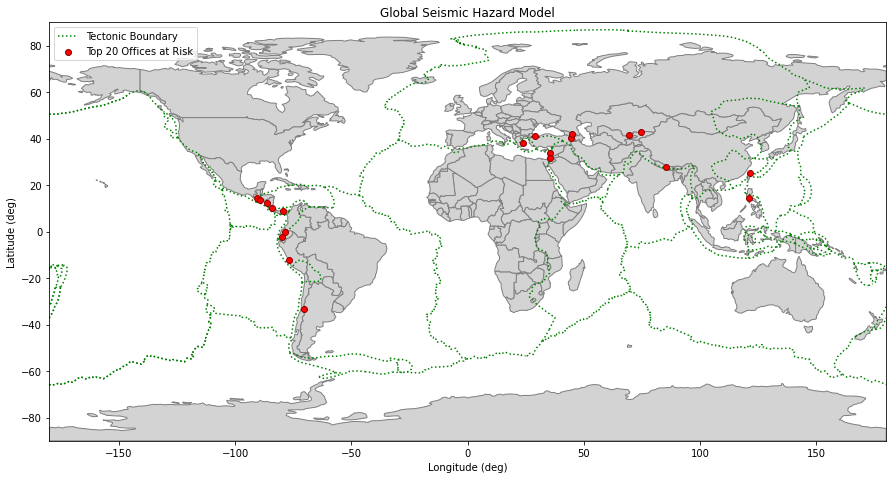

In [ ]:
# grab the top 20 in the sorted array
office_locations_at_risk = office_locations.sort_values(by='Peak Ground Acceleration',ascending=False).head(20)

# plot the world as a base map
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray',zorder=0)
# plot the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundary',zorder=1)
# plot the locations
office_locations_at_risk.plot(ax=ax_world, color='red', edgecolor='darkred', label='Top 20 Offices at Risk')
# show the legend
leg = ax_world.legend(loc='upper left');
# label the axes
ax_world.set_xlabel('Longitude (deg)')
ax_world.set_ylabel('Latitude (deg)')
# title
ax_world.set_title('Global Seismic Hazard Model')
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

We create a plot to go with the executive summary matching the colors.

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


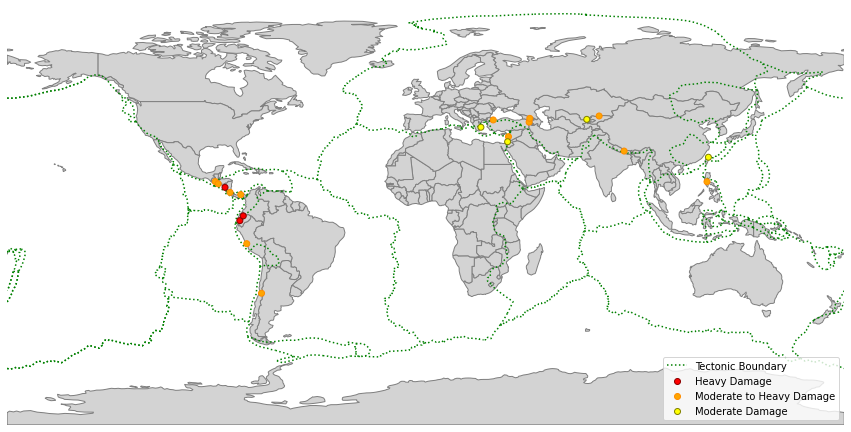

In [ ]:
# grab the top 20 in the sorted array
office_locations_at_risk = office_locations.sort_values(by='Peak Ground Acceleration',ascending=False).head(20)

# plot the world as a base map
ax_world = world.plot(figsize=(15,15), color='lightgray', edgecolor='gray',zorder=0)
# plot the tectonic boundaries
tectonic_boundaries.plot(ax=ax_world, color='green', linestyle=':', label='Tectonic Boundary',zorder=1)
# plot the locations
colors      = ['red']*3      + ['orange']*13      + ['yellow']*4
edge_colors = ['darkred']*3  + ['darkorange']*13  + [(0.5,0.5,0,1)]*4
office_locations_at_risk.plot(ax=ax_world, color=colors, edgecolor=edge_colors)
# add placeholders so I can manually change the color
office_locations_at_risk.plot(ax=ax_world, color='none', label='Heavy Damage')
office_locations_at_risk.plot(ax=ax_world, color='none', label='Moderate to Heavy Damage')
office_locations_at_risk.plot(ax=ax_world, color='none', label='Moderate Damage')
# show the legend
leg = ax_world.legend(loc='lower right');
# manually set the earthquakes color on the legend
leg.legendHandles[1].set_color('red')
leg.legendHandles[1].set_edgecolor('darkred')
leg.legendHandles[2].set_color('orange')
leg.legendHandles[2].set_edgecolor('darkorange')
leg.legendHandles[3].set_color('yellow') # mpl.colors.to_rgba('yellow') = (1,1,0,1)
leg.legendHandles[3].set_edgecolor((0.5,0.5,0,1)) # there is no dark yellow
# hide the axis
ax_world.axis('off')
ax_world.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# axes limits
ax_world.set_xlim([-180, 180])
ax_world.set_ylim([-90, 90]);

## Similarity Measure Between Risk Orderings

In this section we calculate the similarity between the risk orderings using different methods. 

In [ ]:
# package for computing distances between strings and arrays
!pip install textdistance
import textdistance

# sort by PGA value
office_locations.sort_values(by='Peak Ground Acceleration',ascending=False,inplace=True)

# add a unique id to each office location
office_locations['id'] = range(len(office_locations))

# extract PGA ordering
PGA_order = list(office_locations['id'])

# sort by amplitude sum total
office_locations.sort_values(by='Amplitude Sum Total',ascending=False,inplace=True)

# extract amplitude ordering
amplitude_order = list(office_locations['id'])

# sort by density
office_locations.sort_values(by='Earthquake Density', ascending=False, inplace=True)

# extract distance ordering
density_order = list(office_locations['id'])

# sort by distance
office_locations.sort_values(by='Distance to Tectonic', inplace=True)

# extract distance ordering
distance_order = list(office_locations['id'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We use the Jaro–Winkler distance because it uses a prefix scale which gives more favourable ratings to strings that match from the beginning for a set prefix length. Other distance measurements like Levenshtein do not give this prefix preference. We want a prefix preference because the offices with the highest risk are likely sorted in a better order than the offices with low risk. This is due to the fact that there is more data available near the offices with high risk than the ones with low risk. 

In [ ]:
# compute all of the combinations (the distance is reflexive)
PGA_amplitude      = textdistance.jaro_winkler.normalized_similarity(PGA_order,amplitude_order)
PGA_density        = textdistance.jaro_winkler.normalized_similarity(PGA_order,density_order)
PGA_distance       = textdistance.jaro_winkler.normalized_similarity(PGA_order,distance_order)
amplitude_density  = textdistance.jaro_winkler.normalized_similarity(amplitude_order,density_order)
amplitude_distance = textdistance.jaro_winkler.normalized_similarity(amplitude_order,distance_order)
density_distance   = textdistance.jaro_winkler.normalized_similarity(density_order,distance_order)

# build a table of values: PGA, amplitude, density, distance
similarities = np.array([[1, PGA_amplitude, PGA_density, PGA_distance], 
                         [PGA_amplitude, 1, amplitude_density, amplitude_distance],
                         [PGA_density, amplitude_density, 1, density_distance],
                         [PGA_distance,amplitude_distance,density_distance, 1]])

# show the table
labels = ['Peak Ground Acceleration', 'Amplitude Sum Total', 'Earthquake Density','Distance to Tectonic']
pd.DataFrame(similarities, columns=labels, index=labels)


,Peak Ground Acceleration,Amplitude Sum Total,Earthquake Density,Distance to Tectonic
Peak Ground Acceleration,1.000000,0.765204,0.774153,0.758547
Amplitude Sum Total,0.765204,1.000000,0.838542,0.817112
Earthquake Density,0.774153,0.838542,1.000000,0.803449
Distance to Tectonic,0.758547,0.817112,0.803449,1.000000
